## 1. Setting & Data Import


### 데이터 분석 준비


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("ggplot")

In [3]:
import pandas as pd
import numpy as np

In [4]:
import random
np.random.seed(1234)
random.seed(1234)

In [5]:
import warnings
warnings.filterwarnings("ignore")

#### 데이터 불러오기


In [6]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
submission = pd.read_csv("./sample_submission.csv")

In [7]:
# 트레인셋 확인
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# 테스트셋 확인
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
# 트레인-테스트셋 크기 확인
print(train_df.shape, test_df.shape)

(1460, 81) (1459, 80)


## 2. Make baseline


### 벤치마크용 베이스라인 작성하기


### 모델을 작성하기 위해 주어진 설명 변수를 확인하거나 데이터의 분포, 결측치를 탐색하는 등 전처리 과정을 진행해야 함

### 하지만, 먼저 최소한의 카테고리 변수를 라벨 인코딩 처리한 후 LightGBM에 그대로 만들었을 때 정확도가 얼마인지 검증함

### 이런 처리방법을 벤치마크 모델이라 부름

### 벤치마크 모델은 추후 전처리가 정확도 향상에 얼마나 효과가 있는지 검증하기 위함


#### 학습 데이터의 변수 유형 확인하기


In [10]:
'''
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
'''

"\npd.set_option('display.max_columns', None)\npd.set_option('display.max_rows', None)\n"

In [11]:
# 데이터 타입 확인
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

##### 특성 설명

##### 특성이 81개가 있어 전부 기입하긴 어려움

##### 캐글, 현업에선 특성공학으로 늘린경우가 아닌 기초 특성이 매우 많은경우 variable_describe.txt 또는 README.text로 변수에 대한 설명을 따로 빼놓음


In [12]:
# 거주지역의 구역 분류
'''
C - 상업 (Commercial)
FV - 떠다니는 마을 주거지역 (Floating Village Residential)
I - 산업 (Industrial)
RH - 주거지역 고밀도 (Residential High Density)
RL - 주거지역 저밀도 (Residential Low Density)
RP - 주거지역 저밀도 공원 (Residential Low Density Park)
RM - 주거지역 중밀도 (Residential Medium Density)
'''
train_df["MSZoning"].value_counts()
# 카테고리형 변수인걸 확인

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

#### 학습 데이터와 테스트 데이터를 합해서 전처리하기


In [13]:
# 학습데이터 + 테스트데이터 합치기
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [14]:
# 전체데이터셋 확인
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


#### 목적 변수인 SalePrice 값 확인하기


In [15]:
# 종속변수 확인 - 추후에 트레인, 테스트셋 분류에 활용
all_df["SalePrice"]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

#### 카테고리 변수를 수치로 변환하기


In [16]:
# 라벨인코더로 인코딩할때 주의사항
# 결측치를 미리 처리해야함(삭제하거나, 보정하거나)
# 단, 차고(Garage)와 같이 의미 있는 NaN값을 반드시 고려하여야 함
# 이 데이터에서 차고의 NaN값은 차고가 없음을 의미
from sklearn.preprocessing import LabelEncoder

In [17]:
# 데이터의 타입이 object인 특성만 출력
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [18]:
# 종속변수 중 하나 확인
'''
Alley: Type of alley access to property

       Grvl	Gravel - 자갈로 되어 있다
       Pave	Paved - 포장되어있다
       NA 	No alley access  - 골목으로 접근이 불가능하다(도로 손질이 안되어있다.)
'''
all_df["Alley"].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [19]:
# 라벨인코더 먹이기
# NaN값은 missing으로 처리
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [20]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


#### 데이터를 train_df와 test_df로 되돌리기


In [21]:
# 데이터를 train set - test set으로 나누기
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [22]:
print(train_df_le.shape, test_df_le.shape)

(1460, 81) (1459, 81)


#### LightGBM으로 데이터 읽기


In [23]:
# 기본 라이트GBM 읽기
import lightgbm as lgb

In [24]:
# 교차검증용 라이브러리 임포트(3폴드)
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

In [25]:
# 기본 파라미터만 설정
lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

In [26]:
# 학습하기전 트레인셋을 특성데이터셋(학습셋), 정답데이터셋(타깃데이터)로 분류
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice"]

In [27]:
# 정확도 검증 라이브러리 임포트
from sklearn.metrics import mean_squared_error
# from platform import python_version
#print(python_version())

In [28]:
models = []
rmses = []
oof = np.zeros(len(train_X))  # out of fold(선택받지 못한 데이터를 제외한 나머지 데이터를 이용하여 종속변수를 예측한 값 - 우선 0으로 세팅)

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4  ...   

TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# 평균 RMSE 계산
sum(rmses)/len(rmses)

0.1359164479233318

In [ ]:
# 현재 예측값과 실제 값 차이 확인
# 예측값은 oof, 실제값은 train_y이므로 해당 데이터를 데이터프레임화한 후 시각화
actual_pred_df = pd.DataFrame({
    "actual" : train_Y,
    "pred" : oof })

In [ ]:
actual_pred_df

,actual,pred
0,208500.0,201697.867935
1,181500.0,177890.985085
2,223500.0,217051.772774
3,140000.0,182741.413375
4,250000.0,292685.860822
...,...,...
1455,175000.0,177659.212350
1456,210000.0,192814.470692
1457,266500.0,264030.250811
1458,142125.0,138874.491720


<Axes: >

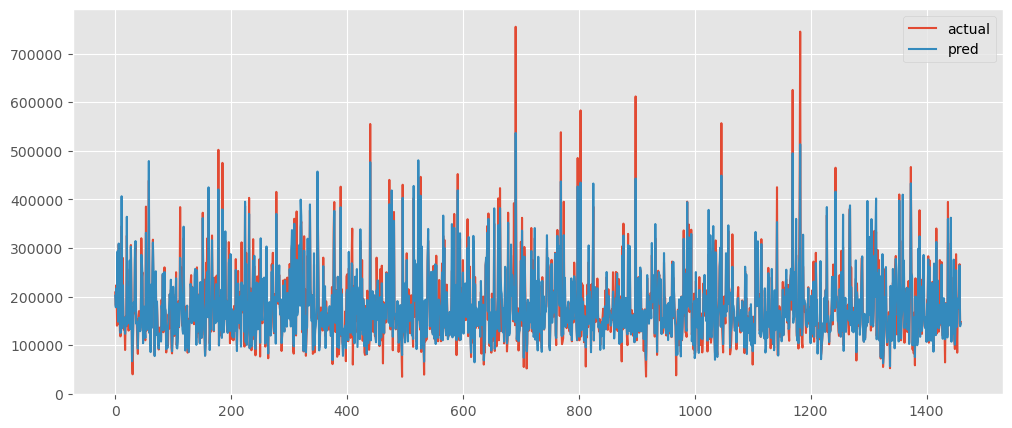

In [ ]:
# 라인그래프로 출력
actual_pred_df.plot(figsize=(12,5))

# 예측값이 실제값을 어느정도 따라가는 것처럼 보임
# 하지만 실제 값이 많이 올라갈 때 예측값이 충분히 따라가보이지는 않음(방어적)
# 이런 값들을 파악하고자 어떻게 접근해야할지, 일반적인 경향과는 다른 이상치를 학습에서 제외해야할지 검토해야함

### 각 변수의 중요도 확인하기


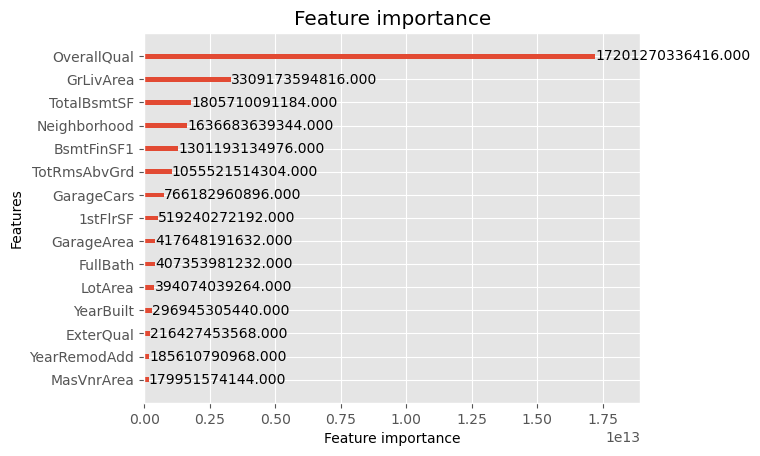

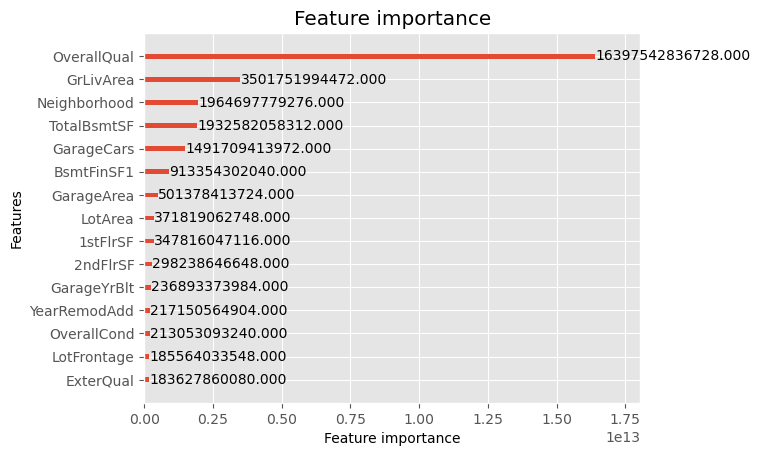

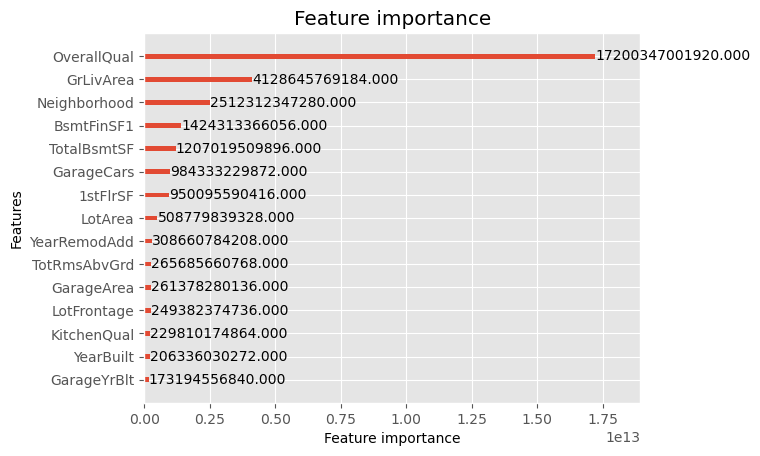

In [ ]:
# 특성 중요도 확인
# 특성이 너무 많기 때문에 15개의 주요특성으로 제한
for model in models:
    lgb.plot_importance(model,importance_type="gain", max_num_features=15)
    
# 세개의 모델 모두 OverallQual이 가장 높은 수치(주택전체의 재료의 질과 마감 등 전반적인 퀄리티)
# GrLivArea는 주거영역의 크기를 의미

## 3. Preprocessing(object variable)


### 목적 변수의 전처리: 목적 변수의 분포 확인하기


#### SalePrice 데이터의 분포 확인하기


In [ ]:
# 다양한 변수를 상세확인하며 전처리 시작
# 타깃값의 분포 확인
train_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='Frequency'>

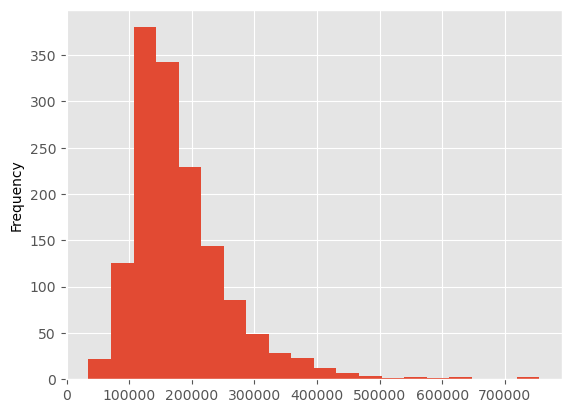

In [ ]:
# 히스토그램 시각화(연속형 데이터 확인)
# 정규분포를 만족하지 않고있음(왼쪽으로 치우쳐저 있는 분포를 푸아송 분포라고함)
# 푸아송분포 - 잘 일어나지 않는 사건이 가장 많은 경우
train_df["SalePrice"].plot.hist(bins=20)

#### 목적 변수를 로그화하기


In [ ]:
# 일반적인 머신러닝, 통계처리의 대부분은 데이터가 정규분포를 만족한다는 가정하에 진행함
# 실제값과 예측값 로그인 RMSE가 지표이므로
# 종속변수를 로그화하여 정규분포를 만족시키고 진행하면 최적화가 쉬워짐
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<Axes: ylabel='Frequency'>

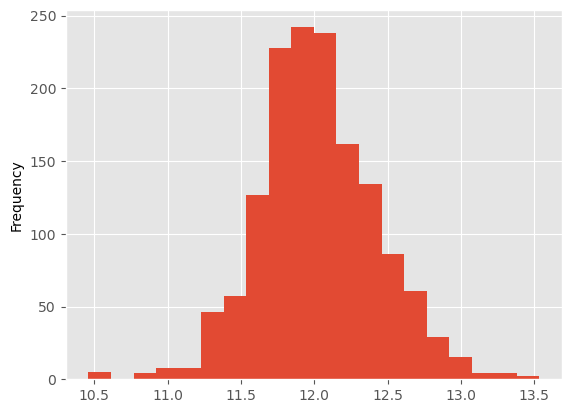

In [ ]:
# 정규분포를 만족하는 히스토그램
# 이 데이터로 최적화를 진행하고 나중에 지수변환을 적용하여 최종적은 submit파일을 작성
np.log(train_df['SalePrice']).plot.hist(bins=20)

#### 목적 변수를 로그화하여 예측 정확도 향상시키기


In [ ]:
# 종속변수 로그화
pd.options.mode.chained_assignment = None  #체인연산 오류 메시지 삭제
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [ ]:
# 특성셋, 타깃데이터 나누기
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2964
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0219638
[30]	valid_0's l2: 0.0178863
[40]	valid_0's l2: 0.0168272
[50]	valid_0's l2: 0.0165421
[60]	valid_0's l2: 0.0164067
[70]	valid_0's l2: 0.0163235
[80]	valid_0's l2: 0.0162611
[90]	valid_0's l2: 0.0162673
[100]	valid_0's l2: 0.0163207
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 0.0162538
0.12749050377720023
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2985
[LightGB

In [ ]:
sum(rmses)/len(rmses)

0.13274830975285581

## 4. Preproccesing(Explanatory variable)


### 설명 변수의 전처리: 결측치 확인하기


#### 각 설명 변수의 결측치 확인


In [ ]:
# all_df로 다시합치기
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [ ]:
all_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [ ]:
# 카테고리셋 분류
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [ ]:
# 결측치수가 많은 컬럼중 상위 40개
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
dtype: int64

#### 결측치가 많은 고급 주택 설비에 관한 변수 정리하기


In [ ]:
'''
PoolQC           2909
MiscFeature      2814
Alley            2721
이 세가지 변수는 모두 고급 주택 관련 설비 항목임
따라서 이 변수들을 모두 고급 설비의 유무 변수로 묶고
원래 데이터는 삭제
'''
# PoolQC 고유값 확인
# 즉, 고급설비 유무로 묶은 뒤 값이 있으면 1, 없으면 0으로 치환
all_df.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [ ]:
# null이 아니면 1, null이면 0으로 변환
all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0

In [ ]:
all_df.PoolQC.value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [ ]:
# MiscFeature도 적용
all_df.loc[~all_df["MiscFeature"].isnull(), "MiscFeature"] = 1
all_df.loc[all_df["MiscFeature"].isnull(), "MiscFeature"] = 0

In [ ]:
# Alley도 적용
all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 1
all_df.loc[all_df["Alley"].isnull(), "Alley"] = 0

In [ ]:
# for문으로 적용할 경우
HighFacility_col = ["PoolQC","MiscFeature","Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

In [ ]:
# 데이터프레임에 세 컬럼을 하나로 묶기
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]

In [ ]:
# 현재 묶인 데이터타입은 object이므로 int형으로 변환
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

In [ ]:
# 고유값 확인
all_df["hasHighFacility"].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

In [ ]:
# 기존 컬럼 삭제
all_df = all_df.drop(["PoolQC","MiscFeature","Alley"],axis=1)

## 5. Outlier


### 이상치 제외하기


#### 각 변수의 통계량 확인하기


In [ ]:
# 이상치인지 확인하기 위한 첫번째 단계
# 각 변수의 통계량 확인
# 평균에서 표준편차에 대해 최솟값, 최댓값이 크게 벗어나 있는 경우거나
# 0 또는 특정값 이외에 취하지 않는 변수가 이상치가 포함되어 있을 수 있음
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


#### 수치 데이터만 추출하기


In [ ]:
# 수치데이터만 추출하기
train_df_num = train_df.select_dtypes(include=[np.number])  #수치데이터 여부는 np.number로 확인 가능

In [ ]:
train_df_num

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


### 수치데이터는 크게 질적변수와 양적변수로 나뉨

### 질적변수는 명목척도와 순서척도로 나뉨

### 양적변수는 간격척도와 비례척도로 나뉨

#### 명목척도: 분류를 위한 것(예시\_타이타닉에서 방번호, 티켓번호 등등)

#### 순서척도: 순서에 의미가 있는 것(예시\_ 티켓 등급은 1, 2, 3 순서에 의미가 있음)

#### 간격척도: 간격을 측정하는 것(예시\_눈금이 곧 간격인 것(온도는 32번째 눈금과 31번째 눈금간 간격이 곧 값으로 치환가능함)

#### 비례척도: 비율에 의미가 있는 것(예시\_ 간격척도의 조건을 만족시키는 것 중에서 원점에서 데이터 비율에 의미가 있는 데이터를 말함 예로 티켓 요금의 경우 3달러가 1달러보다 3배 비쌈, 72세의 노인은 8세의 아동보다 9배 나이가 많음)


In [ ]:
# 이상치는 편차, 평균 등과 비례하여 판단하여야 하기 때문에 비례척도가 아닌 데이터는 제외하여야 함
nonratio_features = ["Id", "MSSubClass", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MoSold", "YrSold"]

# ID = PK
# MSSubClass = 주택유형 언제지어졌고 이런걸 코드로 표현 (명목척도, 간격척도)
# OverallQual = 전반적인 퀄리티 (순서척도)
# OverallCond = 퀄리티를 등급제로 나눔(10이면 매우좋음 9면 좋음 등등) (순서척도)
# YearBuilt = 지어진 연도(간격척도)
# YearRemodAdd = 리모델링 연도(간격척도)
# MoSold = 주택의 판매월(간격척도)
# YrSold = 주택의 판매년도(간격척도)

In [ ]:
# 원래 데이터에서 비례척도가 아닌 컬럼을 뺀 후, sorted하여 특성명만 저장
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))

In [ ]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [ ]:
# 인덱싱하여 수치형 특성 중 비례척도 데이터만 모은 데이터프레임으로 정리
train_df_num_rs = train_df_num[num_features]

In [ ]:
train_df_num_rs

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,PoolArea,SalePrice,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF
0,856,854,0,3,706,0,1,0,150,0,...,0,196.0,0,61,0,208500,0,8,856,0
1,1262,0,0,3,978,0,0,1,284,0,...,0,0.0,0,0,0,181500,0,6,1262,298
2,920,866,0,3,486,0,1,0,434,0,...,0,162.0,0,42,0,223500,0,6,920,0
3,961,756,0,3,216,0,1,0,540,272,...,0,0.0,0,35,0,140000,0,7,756,0
4,1145,1053,0,4,655,0,1,0,490,0,...,0,350.0,0,84,0,250000,0,9,1145,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694,0,3,0,0,0,0,953,0,...,0,0.0,0,40,0,175000,0,7,953,0
1456,2073,0,0,3,790,163,1,0,589,0,...,0,119.0,0,0,0,210000,0,7,1542,349
1457,1188,1152,0,4,275,0,0,0,877,0,...,0,0.0,2500,60,0,266500,0,9,1152,0
1458,1078,0,0,2,49,1029,1,0,0,112,...,0,0.0,0,0,0,142125,0,5,1078,366


#### 다수의 데이터가 0인 변수 확인하기


In [ ]:
# 결측은 아니지만 대부분이 0으로 채워진 데이터를 확인
# 비율은 75%이상의 값이 0인 특성만 확인
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


#### 특정 값만 가지는 변수 확인하기


In [ ]:
# 특정한 값만 가지는 변수 확인
# 예를들어 BsmtHalfBath는 변기만 있는 화장실(욕실이나 샤워기가 없는 외국의 그 특유의 화장실)의 개수를 의미
# 0,1,2 이렇게 세개만 있음(카테고리 변수로 변환하거나 존재유무 0또는 1로변환)
# 유니크값이 15개 미만인 변수 출력
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


#### 이상치가 있는지 확인하기


In [ ]:
# 이상치가 있는지 확인하기
# 이상치를 찾는 방법 중 가장 간단한 방법은 평균에서 표준편차+-3배 범위에 들어있지 않은 것(96%내의 데이터, p-value신뢰도 0.05미만)
# 즉, 평균을 중심으로 하여 표준편차 3배 이상의 값 또는 표준편차 3배 이하의 값을 찾음
for col in num_features:
    tmp_df = train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3) | \
    (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


#### 이상치를 포함하는 변수의 분포를 시각화하기


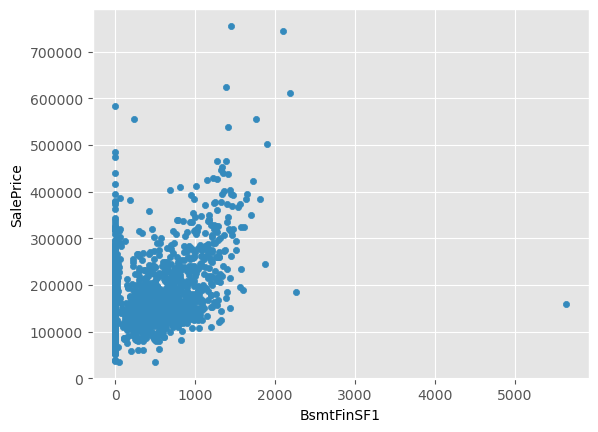

In [ ]:
# 이상치를 포함하여 변수의 분포를 시각화
# 세로축을 종속변수
# 가로축을 각 비례척도 변수로 넣음
# BsmtFinSF1: Type 1 finished square feet = 지하실의 크기(피트)
all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")
plt.show()

In [ ]:
# BsmtFinSF1이 넓지만 SalePrice가 낮은 샘플 확인하기
all_df[all_df["BsmtFinSF1"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


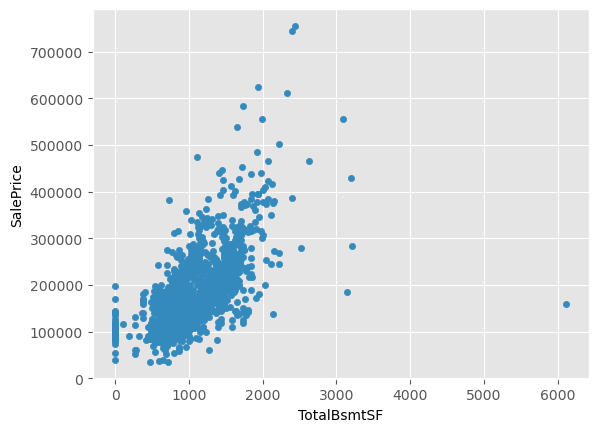

In [ ]:
# 다른 변수도 확인
all_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")
plt.show()

In [ ]:
# 같은 pk임을 확인
all_df[all_df["TotalBsmtSF"] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


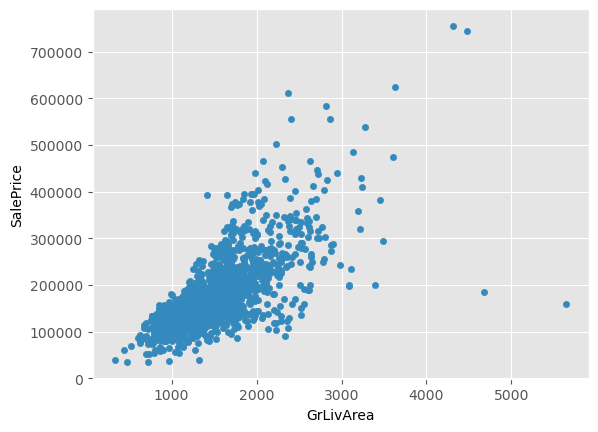

In [ ]:
# 거주크기 변수 확인
all_df.plot.scatter(x="GrLivArea", y="SalePrice")
plt.show()

In [ ]:
all_df[all_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


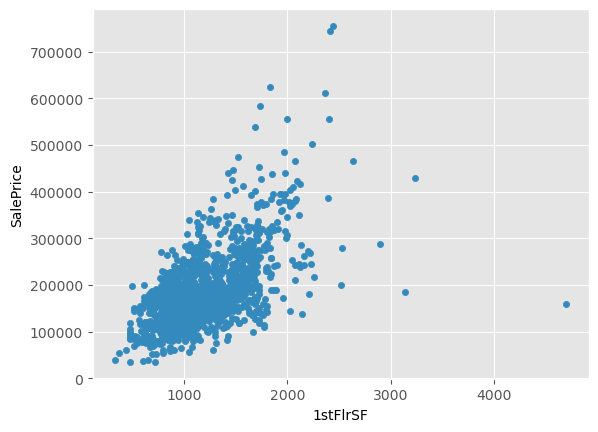

In [ ]:
# 1층의 면적
all_df.plot.scatter(x="1stFlrSF", y="SalePrice")
plt.show()

In [ ]:
all_df[all_df["1stFlrSF"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [ ]:
# 전체 데이터에서 이상치를 제거하고 이상치가 아닌 데이터만 남기기
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

In [ ]:
all_df
# 15개의 이상치 제거

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,2,2008,WD,Normal,208500.0,0
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,NaN,0,5,2007,WD,Normal,181500.0,0
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2008,WD,Normal,223500.0,0
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,NaN,0,2,2006,WD,Abnorml,140000.0,0
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,NaN,0,12,2008,WD,Normal,250000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,6,2006,WD,Normal,NaN,0
2915,2916,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,4,2006,WD,Abnorml,NaN,0
2916,2917,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,...,0,0,NaN,0,9,2006,WD,Abnorml,NaN,0
2917,2918,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,...,0,0,MnPrv,700,7,2006,WD,Normal,NaN,1


### 이상치 제거한 데이터로 RMSE 재산출


In [ ]:
# lightGBM에 넘겨줄 카테고리형 데이터 중, 사라진 데이터 제거
categories = categories.drop(["PoolQC","MiscFeature","Alley"])

In [ ]:
categories

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [ ]:
# 카테고리데이터 라벨인코딩
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [ ]:
# 트레인, 테스트셋 분류
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

# 트레인셋의 종속변수 로그화
# 트레인셋의 특성데이터 - 타깃데이터 분류
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [ ]:
print(train_X.shape, train_Y.shape)

(1445, 77) (1445,)


In [ ]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2949
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0220026
[30]	valid_0's l2: 0.0175682
[40]	valid_0's l2: 0.0163798
[50]	valid_0's l2: 0.0162547
[60]	valid_0's l2: 0.0162622
[70]	valid_0's l2: 0.0162514
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0161791
0.12719701309461987
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2943
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] 

In [ ]:
sum(rmses)/len(rmses)

0.1298064868429131

## 6. Feature Engineering


### 설명 변수의 확인하기: 특징량 생성


#### describe 데이터 파일을 확인해보면 크게 4개분류로 나눌 수 있음

#### 시간과 관련된 데이터(5개): 건축한 해, 수리한 해, 판매한 해 등등

#### 크기와 관련된 데이터(16개): 지하너비, 1층너비 등등

#### 설비 및 허용 범위와 관련된 데이터(9개): 차고에 들어가는 차 대수, 방의갯수 등등

#### 품질 및 분류와 관련된 데이터(50개): 주택품질, 주택상태 등등

#### 새로운 특징을 만들기 위해 사용되는 데이터를 설명변수라함

#### 예로 시간 변수는 건축된 연도 ~ 판매된 연도를 토대로 경과연도(건축후 얼마나 지났는지)를 새로 만들 수 있음


#### 시간과 관련된 변수의 통계량 확인하기


In [ ]:
# 시간과 관련된 데이터 통계요약 - 연도기준
# 이상치가 있나요? 당연히 없음 그리고 연도에서 이상치가 있는경우는 오기입을 확인해야함
all_df[["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold"]].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [ ]:
# 새로운 특징값 추가
# 건축 후 몇년이 경과됐을 때 판매되었는가
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

In [ ]:
all_df["Age"]

0        5
1       31
2        7
3       91
4        8
        ..
2914    36
2915    36
2916    46
2917    14
2918    13
Name: Age, Length: 2904, dtype: int64

In [ ]:
# 재학습
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [ ]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3046
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 73
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.042401
[20]	valid_0's l2: 0.0217498
[30]	valid_0's l2: 0.0175187
[40]	valid_0's l2: 0.0162941
[50]	valid_0's l2: 0.0160985
[60]	valid_0's l2: 0.0160802
[70]	valid_0's l2: 0.0161142
[80]	valid_0's l2: 0.016149
Early stopping, best iteration is:
[68]	valid_0's l2: 0.0160466
0.1266752634099996
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 963, number of used featu

In [ ]:
sum(rmses)/len(rmses)

0.12939563041691993

#### 넓이 변수로 새로운 특징량 작성하기


In [ ]:
# 너비변수의 통계량 확인
# LotArea=부지면적
# Porch = 베란다
all_df[["LotArea","MasVnrArea","BsmtUnfSF","TotalBsmtSF", 
        "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", 
        "GarageArea","WoodDeckSF", "OpenPorchSF", "EnclosedPorch", 
        "3SsnPorch", "ScreenPorch", "PoolArea", "LotFrontage"]].describe().T

,count,mean,std,min,25%,50%,75%,max
LotArea,2904.0,9912.604683,5178.128224,1300.0,7448.25,9422.0,11503.00,70761.0
MasVnrArea,2882.0,101.191187,177.804595,0.0,0.00,0.0,164.00,1600.0
BsmtUnfSF,2903.0,559.850499,438.438879,0.0,220.00,467.0,802.50,2336.0
TotalBsmtSF,2903.0,1043.794006,420.008348,0.0,791.50,988.0,1296.00,5095.0
1stFlrSF,2904.0,1152.707300,377.291394,334.0,875.75,1080.0,1381.25,5095.0
2ndFlrSF,2904.0,336.355372,427.355787,0.0,0.00,0.0,704.00,1872.0
LowQualFinSF,2904.0,4.718664,46.515308,0.0,0.00,0.0,0.00,1064.0
GrLivArea,2904.0,1493.781336,491.149725,334.0,1124.00,1441.0,1739.25,5095.0
GarageArea,2903.0,471.632794,214.551791,0.0,319.50,478.0,576.00,1488.0
WoodDeckSF,2904.0,93.265840,125.855568,0.0,0.00,0.0,168.00,1424.0


In [ ]:
# 새 특징 생성
# 1층의 너비+2층의 너비를 전체 너비로 생성
# 모든 욕실형태를 합쳐 전체 욕실수로 생성
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

In [ ]:
# 모든 베란다 형태를 합치기
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]

In [ ]:
# 베란다가 있으면 1, 없으면 0으로 치환
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF",axis=1)

In [ ]:
all_df["hasPorch"]

0       1
1       1
2       1
3       1
4       1
       ..
2914    0
2915    1
2916    1
2917    1
2918    1
Name: hasPorch, Length: 2904, dtype: int64

In [ ]:
# 재학습
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [ ]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0382198
[20]	valid_0's l2: 0.0195098
[30]	valid_0's l2: 0.0163133
[40]	valid_0's l2: 0.0155157
[50]	valid_0's l2: 0.0154576
[60]	valid_0's l2: 0.0155145
Early stopping, best iteration is:
[48]	valid_0's l2: 0.0154265
0.12420330159076388
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3300
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.

In [ ]:
sum(rmses)/len(rmses)

0.128396868966143

## 7. Hyper Parameter Optimization


### 하이퍼파라미터 최적화하기


#### Optuna를 이용해 하이퍼파라미터 최적화하기


In [ ]:
!pip install optuna

     ------------------------------------- 390.6/390.6 kB 12.3 MB/s eta 0:00:00
     ------------------------------------- 224.5/224.5 kB 13.4 MB/s eta 0:00:00
     ---------------------------------------- 78.7/78.7 kB ? eta 0:00:00


In [ ]:
# 그리드서치, 랜덤서치를 최적화한 optuna 임포트
import optuna

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, 
                                                      random_state=1234, shuffle=False,  stratify=None)

In [ ]:
def objective(trial):  # trial 파라미터 객체 전달받아서 수행
    params = {
        "objective":"regression",  #objective 회귀
        "random_seed":1234,  # 랜덤시드 설정
        "learning_rate":0.05,  # Gradient Boosting 알고리즘에서 각 트리의 영향력을 얼마나 반영할지 결정    
        "n_estimators":1000,  # 트리의 개수를 설정
        
        "num_leaves":trial.suggest_int("num_leaves",4,64), #하나의 트리에서 사용될 최대 잎(리프)의 개수를 설정
        "max_bin":trial.suggest_int("max_bin",50,200), #히스토그램 기반 트리 학습 시에 사용되는 bin(구간)의 최대 개수를 설정       
        "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9), #부트스트랩 샘플링(Bagging)에서 사용될 데이터의 비율
        "bagging_freq":trial.suggest_int("bagging_freq",1,10),  #부트스트랩 샘플링 시 데이터를 사용하는 빈도를 설정
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9), #각 트리를 학습할 때 사용되는 특성의 비율을 설정
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf",2,16), #하나의 리프노드에 포함될 최소 데이터 개수를 설정               
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf",1,10), #리프노드 가중치 합의 최소 값(분할개수)
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(params, lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,)    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score =  np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

In [ ]:
# 함수를 사용하여 학습
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)  #50회 시행
study.best_params

[I 2023-07-21 18:14:00,656] A new study created in memory with name: no-name-279f37da-4336-4fe8-b941-5893a6e75809


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0659468
[20]	valid_0's l2: 0.0360287
[30]	valid_0's l2: 0.0239196
[40]	valid_0's l2: 0.0183967
[50]	valid_0's l2: 0.0161611
[60]	valid_0's l2: 0.015461
[70]	valid_0's l2: 0.0148438
[80]	valid_0's l2: 0.0145826
[90]	valid_0's l2: 0.0144628
[100]	valid_0's l2: 0.0143176
[110]	valid_0's l2: 0.0142316
[120]	valid_0's l2: 0.0142159


[I 2023-07-21 18:14:00,957] Trial 0 finished with value: 0.11921948775949834 and parameters: {'num_leaves': 37, 'max_bin': 157, 'bagging_fraction': 0.7013816880358219, 'bagging_freq': 6, 'feature_fraction': 0.6118273996694523, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 0 with value: 0.11921948775949834.


[130]	valid_0's l2: 0.0142722
Early stopping, best iteration is:
[119]	valid_0's l2: 0.0142133
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3097
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2023-07-21 18:14:01,130] Trial 1 finished with value: 0.12012901418633552 and parameters: {'num_leaves': 58, 'max_bin': 195, 'bagging_fraction': 0.5917207594128888, 'bagging_freq': 8, 'feature_fraction': 0.6644474598764523, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949834.
[I 2023-07-21 18:14:01,227] Trial 2 finished with value: 0.12243462195761393 and parameters: {'num_leaves': 8, 'max_bin': 63, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 9, 'feature_fraction': 0.7890783754749253, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949834.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0723969
[20]	valid_0's l2: 0.0430363
[30]	valid_0's l2: 0.0303053
[40]	valid_0's l2: 0.0239242
[50]	valid_0's l2: 0.0202706
[60]	valid_0's l2: 0.0183297
[70]	valid_0's l2: 0.0171541
[80]	valid_0's l2: 0.0162883
[90]	valid_0's l2: 0.0158127
[100]	valid_0's l2: 0.0154521
[110]	valid_0's l2: 0.0149976
[120]	valid_0's l2: 0.0150278
[130]	valid_0's l2: 0.0150877
Early stopping, best iteration is:
[113]	valid_0's l2: 0.0149902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_col_wise=true` to remo

[I 2023-07-21 18:14:01,545] Trial 3 finished with value: 0.11948763685441077 and parameters: {'num_leaves': 52, 'max_bin': 119, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 2, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.11921948775949834.


[60]	valid_0's l2: 0.0155843
[70]	valid_0's l2: 0.0151748
[80]	valid_0's l2: 0.014894
[90]	valid_0's l2: 0.0148207
[100]	valid_0's l2: 0.0146971
[110]	valid_0's l2: 0.0146044
[120]	valid_0's l2: 0.0145469
[130]	valid_0's l2: 0.0144888
[140]	valid_0's l2: 0.0143614
[150]	valid_0's l2: 0.014341
[160]	valid_0's l2: 0.0143097
[170]	valid_0's l2: 0.0143001
Early stopping, best iteration is:
[157]	valid_0's l2: 0.0142773
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2276
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066408
[20]	valid_0's l2: 0.0363539
[30]	valid_0's l2: 0.0242351
[40]	valid_0's l2: 0.0189323
[50]	valid_0's l2: 0.0162179
[60]	valid_0's l2: 0.0147991
[7

[I 2023-07-21 18:14:01,926] Trial 4 finished with value: 0.11621335807143585 and parameters: {'num_leaves': 35, 'max_bin': 112, 'bagging_fraction': 0.5322778060523135, 'bagging_freq': 8, 'feature_fraction': 0.6280751661082743, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143585.


[120]	valid_0's l2: 0.0138189
[130]	valid_0's l2: 0.0137193
[140]	valid_0's l2: 0.0137243
[150]	valid_0's l2: 0.0135936
[160]	valid_0's l2: 0.0135242
[170]	valid_0's l2: 0.0135713
[180]	valid_0's l2: 0.0136351
Early stopping, best iteration is:
[161]	valid_0's l2: 0.0135055
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0639992


[I 2023-07-21 18:14:02,167] Trial 5 finished with value: 0.12288551018586134 and parameters: {'num_leaves': 41, 'max_bin': 142, 'bagging_fraction': 0.7084669984373785, 'bagging_freq': 10, 'feature_fraction': 0.7409101495517417, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143585.


[20]	valid_0's l2: 0.0357102
[30]	valid_0's l2: 0.0236082
[40]	valid_0's l2: 0.0186928
[50]	valid_0's l2: 0.016742
[60]	valid_0's l2: 0.0157799
[70]	valid_0's l2: 0.0155055
[80]	valid_0's l2: 0.0152684
[90]	valid_0's l2: 0.0151588
[100]	valid_0's l2: 0.0151961
[110]	valid_0's l2: 0.0152685
Early stopping, best iteration is:
[94]	valid_0's l2: 0.0151008
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1500
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0650692
[20]	valid_0's l2: 0.035213
[30]	valid_0's l2: 0.0235695
[40]	valid_0's l2: 0.0189368
[50]	valid_0's l2: 0.0171787
[60]	valid_0's l2: 0.0162984
[7

[I 2023-07-21 18:14:02,536] Trial 6 finished with value: 0.12372288602804948 and parameters: {'num_leaves': 46, 'max_bin': 59, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 7, 'feature_fraction': 0.5051912805369205, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


[140]	valid_0's l2: 0.0153525
[150]	valid_0's l2: 0.0153259
[160]	valid_0's l2: 0.0153393
[170]	valid_0's l2: 0.015381
Early stopping, best iteration is:
[152]	valid_0's l2: 0.0153074
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0685588
[20]	valid_0's l2: 0.0385705
[30]	valid_0's l2: 0.0262354
[40]	valid_0's l2: 0.0206248
[50]	valid_0's l2: 0.017847
[60]	valid_0's l2: 0.0167885
[70]	valid_0's l2: 0.0160365


[I 2023-07-21 18:14:02,792] Trial 7 finished with value: 0.12325661836479342 and parameters: {'num_leaves': 26, 'max_bin': 136, 'bagging_fraction': 0.6193007567311601, 'bagging_freq': 10, 'feature_fraction': 0.45102240537401406, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143585.


[80]	valid_0's l2: 0.0157248
[90]	valid_0's l2: 0.0156422
[100]	valid_0's l2: 0.0155114
[110]	valid_0's l2: 0.0154175
[120]	valid_0's l2: 0.015317
[130]	valid_0's l2: 0.0151995
[140]	valid_0's l2: 0.0152626
[150]	valid_0's l2: 0.0152446
Early stopping, best iteration is:
[134]	valid_0's l2: 0.0151922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653917
[20]	valid_0's l2: 0.0353138
[30]	valid_0's l2: 0.0236292
[40]	valid_0's l2: 0.0191997
[50]	valid_0's l2: 0.0170269
[60]	valid_0's l2: 0.0159562
[70]	valid_0's l2: 0.015702
[80]	valid_0's l2: 0.0155463
[90]	valid_0's l2: 0.0154414
[100]	valid_0's l2: 0.0153966
[1

[I 2023-07-21 18:14:03,129] Trial 8 finished with value: 0.123200368396042 and parameters: {'num_leaves': 43, 'max_bin': 88, 'bagging_fraction': 0.6331553864281532, 'bagging_freq': 3, 'feature_fraction': 0.4794847918227599, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


Early stopping, best iteration is:
[159]	valid_0's l2: 0.0151783
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1819
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0720131
[20]	valid_0's l2: 0.0421651
[30]	valid_0's l2: 0.0286681
[40]	valid_0's l2: 0.0219793
[50]	valid_0's l2: 0.0183408
[60]	valid_0's l2: 0.0164611
[70]	valid_0's l2: 0.01556
[80]	valid_0's l2: 0.015073
[90]	valid_0's l2: 0.0147495
[100]	valid_0's l2: 0.0145849
[110]	valid_0's l2: 0.0144036
[120]	valid_0's l2: 0.014341
[130]	valid_0's l2: 0.0143924
[140]	valid_0's l2: 0.0141699
[150]	valid_0's l2: 0.014075
[160]	valid_0's l2: 0.0140664

[I 2023-07-21 18:14:03,324] Trial 9 finished with value: 0.11833930321635734 and parameters: {'num_leaves': 12, 'max_bin': 79, 'bagging_fraction': 0.5843625853304821, 'bagging_freq': 9, 'feature_fraction': 0.44855063789653066, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2368
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0645947
[20]	valid_0's l2: 0.0349
[30]	valid_0's l2: 0.0239167
[40]	valid_0's l2: 0.019325
[50]	valid_0's l2: 0.017922
[60]	valid_0's l2: 0.017351
[70]	valid_0's l2: 0.0171303
[80]	valid_0's l2: 0.0171538
[90]	valid_0's l2: 0.0170625
[100]	valid_0's l2: 0.0169556
[110]	valid_0's l2: 0.0169456
[120]	valid_0's l2: 0.0168885
[130]	valid_0's l2: 0.0168479
[140]	valid_0's l2: 0.0168025
[150]	valid_0's l2: 0.0167815
[160]	valid_0's l2: 0.0168289
[170]	valid_0's l2: 0.0168183
Early stopping, best iteration is:
[150]	valid_0's l2: 0.0167815


[I 2023-07-21 18:14:03,763] Trial 10 finished with value: 0.1295435415929816 and parameters: {'num_leaves': 63, 'max_bin': 120, 'bagging_fraction': 0.8883805440951686, 'bagging_freq': 7, 'feature_fraction': 0.7696317896991509, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11621335807143585.
[I 2023-07-21 18:14:03,918] Trial 11 finished with value: 0.11983377452964886 and parameters: {'num_leaves': 11, 'max_bin': 94, 'bagging_fraction': 0.45936385947712205, 'bagging_freq': 4, 'feature_fraction': 0.607131497257335, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0723296
[20]	valid_0's l2: 0.0424445
[30]	valid_0's l2: 0.0284022
[40]	valid_0's l2: 0.0222346
[50]	valid_0's l2: 0.0189382
[60]	valid_0's l2: 0.0171733
[70]	valid_0's l2: 0.0163607
[80]	valid_0's l2: 0.0154663
[90]	valid_0's l2: 0.0151567
[100]	valid_0's l2: 0.0149257
[110]	valid_0's l2: 0.0147376
[120]	valid_0's l2: 0.0145206
[130]	valid_0's l2: 0.0145659
[140]	valid_0's l2: 0.0145321
[150]	valid_0's l2: 0.0144151
[160]	valid_0's l2: 0.0143894
[170]	valid_0's l2: 0.0144635
[180]	valid_0's l2: 0.0146086
Early stopping, best iteration is:
[163]	valid_0's l2: 0.014360

[I 2023-07-21 18:14:04,103] Trial 12 finished with value: 0.12066129587078789 and parameters: {'num_leaves': 38, 'max_bin': 90, 'bagging_fraction': 0.6616240267333499, 'bagging_freq': 1, 'feature_fraction': 0.6879732477780897, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


[20]	valid_0's l2: 0.0355787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's l2: 0.0236788
[40]	valid_0's l2: 0.0185916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's l2: 0.0165607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's l2: 0.0154825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's l2: 0.0149025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	valid_0's l2: 0.0146989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's l2: 0.014613
[100]	valid_0's l2: 0.014646
[110]	valid_0's l2: 0.0146479
Early stopping, best iteration is:


[I 2023-07-21 18:14:04,525] Trial 13 finished with value: 0.1199504383453797 and parameters: {'num_leaves': 44, 'max_bin': 69, 'bagging_fraction': 0.7581636020592828, 'bagging_freq': 3, 'feature_fraction': 0.49159568100355844, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 1}. Best is trial 4 with value: 0.11621335807143585.


[140]	valid_0's l2: 0.014508
[150]	valid_0's l2: 0.0144821
[160]	valid_0's l2: 0.0144311
[170]	valid_0's l2: 0.014398
[180]	valid_0's l2: 0.0144176
[190]	valid_0's l2: 0.0144799
Early stopping, best iteration is:
[171]	valid_0's l2: 0.0143881
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1344
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2023-07-21 18:14:04,816] Trial 14 finished with value: 0.1183866598579404 and parameters: {'num_leaves': 54, 'max_bin': 50, 'bagging_fraction': 0.7389082683981151, 'bagging_freq': 3, 'feature_fraction': 0.7675970110612975, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 3}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's l2: 0.0141645
Early stopping, best iteration is:
[120]	valid_0's l2: 0.0140154
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0652192
[20]	valid_0's l2: 0.0356203
[30]	valid_0's l2: 0.023876
[40]	valid_0's l2: 0.0188538
[50]	valid_0's l2: 0.0170089
[60]	valid_0's l2: 0.0161279
[70]	valid_0's l2: 0.01577

[I 2023-07-21 18:14:05,019] Trial 15 finished with value: 0.12249843914982214 and parameters: {'num_leaves': 39, 'max_bin': 139, 'bagging_fraction': 0.6861259528954367, 'bagging_freq': 3, 'feature_fraction': 0.8763745057584925, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2047
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0654476
[20]	valid_0's l2: 0.0348945
[30]	valid_0's l2: 0.0232133
[40]	valid_0's l2: 0.0186158
[50]	valid_0's l2: 0.0167928
[60]	valid_0's l2: 0.0158671
[70]	valid_0's l2: 0.0151884
[80]	valid_0's l2: 0.014973
[90]	valid_0's l2: 0.0148574
[100]	valid_0's l2: 0.0147908


[I 2023-07-21 18:14:05,355] Trial 16 finished with value: 0.12079833209560319 and parameters: {'num_leaves': 46, 'max_bin': 94, 'bagging_fraction': 0.8068989098512387, 'bagging_freq': 4, 'feature_fraction': 0.8405515985555808, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143585.


[110]	valid_0's l2: 0.0147467
[120]	valid_0's l2: 0.0147442
[130]	valid_0's l2: 0.0147911
[140]	valid_0's l2: 0.0146097
[150]	valid_0's l2: 0.0146298
[160]	valid_0's l2: 0.0146584
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0145922
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0635115
[20]	valid_0's l2: 0.0356727
[30]	valid_0's l2: 0.0241828
[40]	valid_0's l2: 0.0197761


[I 2023-07-21 18:14:05,568] Trial 17 finished with value: 0.12465732708852482 and parameters: {'num_leaves': 46, 'max_bin': 159, 'bagging_fraction': 0.6506621909633512, 'bagging_freq': 10, 'feature_fraction': 0.7219950996148188, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[50]	valid_0's l2: 0.017458
[60]	valid_0's l2: 0.0164014
[70]	valid_0's l2: 0.0161523
[80]	valid_0's l2: 0.015674
[90]	valid_0's l2: 0.0155865
[100]	valid_0's l2: 0.0156389
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0155394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0772015
[20]	valid_0's l2: 0.0488641
[30]	valid_0's l2: 0.034581
[40]	valid_0's l2: 0.0270809
[50]	valid_0's l2: 0.0230393
[60]	valid_0's l2: 0.020913
[70]	valid_0's l2: 0.0198276
[80]	valid_0's l2: 0.018913
[90]	valid_0's l2: 0.0180636
[100]	valid_0's l2: 0.0173222


[I 2023-07-21 18:14:05,796] Trial 18 finished with value: 0.11966528057480719 and parameters: {'num_leaves': 5, 'max_bin': 95, 'bagging_fraction': 0.7300867687463426, 'bagging_freq': 3, 'feature_fraction': 0.7090077144994208, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143585.


[110]	valid_0's l2: 0.0167365
[120]	valid_0's l2: 0.0162763
[130]	valid_0's l2: 0.016011
[140]	valid_0's l2: 0.0157394
[150]	valid_0's l2: 0.0154868
[160]	valid_0's l2: 0.0154228
[170]	valid_0's l2: 0.0153516
[180]	valid_0's l2: 0.0152941
[190]	valid_0's l2: 0.0150688
[200]	valid_0's l2: 0.0149567
[210]	valid_0's l2: 0.0148402
[220]	valid_0's l2: 0.0148004
[230]	valid_0's l2: 0.0146198
[240]	valid_0's l2: 0.0145606
[250]	valid_0's l2: 0.0145366
[260]	valid_0's l2: 0.0144597
[270]	valid_0's l2: 0.0144057
[280]	valid_0's l2: 0.014351
[290]	valid_0's l2: 0.0143398
[300]	valid_0's l2: 0.0143803
Early stopping, best iteration is:
[282]	valid_0's l2: 0.0143198
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2554
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12

[I 2023-07-21 18:14:06,036] Trial 19 finished with value: 0.12002938223871082 and parameters: {'num_leaves': 22, 'max_bin': 136, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 6, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143585.


[40]	valid_0's l2: 0.0194101
[50]	valid_0's l2: 0.016904
[60]	valid_0's l2: 0.0160305
[70]	valid_0's l2: 0.0153439
[80]	valid_0's l2: 0.0148304
[90]	valid_0's l2: 0.0147109
[100]	valid_0's l2: 0.0145076
[110]	valid_0's l2: 0.0145036
[120]	valid_0's l2: 0.0144584
[130]	valid_0's l2: 0.0144166
[140]	valid_0's l2: 0.0145413
[150]	valid_0's l2: 0.0145218
Early stopping, best iteration is:
[131]	valid_0's l2: 0.014407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2023-07-21 18:14:06,385] Trial 20 finished with value: 0.12442620993318665 and parameters: {'num_leaves': 58, 'max_bin': 105, 'bagging_fraction': 0.6179324626328134, 'bagging_freq': 9, 'feature_fraction': 0.8030969945230428, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 2}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's l2: 0.0155497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2023-07-21 18:14:06,806] Trial 21 finished with value: 0.12718774119423695 and parameters: {'num_leaves': 60, 'max_bin': 157, 'bagging_fraction': 0.8994235032839333, 'bagging_freq': 2, 'feature_fraction': 0.8340630286841071, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[130]	valid_0's l2: 0.0162495
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0161767
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0717053
[20]	valid_0's l2: 0.0413166
[30]	valid_0's l2: 0.0279717
[40]	valid_0's l2: 0.0219095
[50]	valid_0's l2: 0.0189611
[60]	valid_0's l2: 0.0172604
[70]	valid_0's l2: 0.0164715
[80]	valid_0's l2: 0.0160482
[90]	valid_0's l2: 0.0157468
[100]	valid_0's l2: 0.0153786
[110]	valid_0's l2: 0.0151728
[120]	valid_0's l2: 0.0149921
[130]	valid_0's l2: 0.0149268
[140]	valid_0's l2: 0.0148403
[150]	valid_0's l2: 0.01

[I 2023-07-21 18:14:06,984] Trial 22 finished with value: 0.12151261222488925 and parameters: {'num_leaves': 11, 'max_bin': 178, 'bagging_fraction': 0.8036594793625054, 'bagging_freq': 6, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2831
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0656779
[20]	valid_0's l2: 0.0362675
[30]	valid_0's l2: 0.0243702
[40]	valid_0's l2: 0.019556
[50]	valid_0's l2: 0.0175464
[60]	valid_0's l2: 0.0166221
[70]	valid_0's l2: 0.016172
[80]	valid_0's l2: 0.0160095
[90]	valid_0's l2: 0.015721
[100]	valid_0's l2: 0.0155644
[110]	valid_0's l2: 0.0154965
[120]	valid_0's l2: 0.0154206
[130]	valid_0's l2: 0.0153846
[140]	valid_0's l2: 0.0154011
[150]	valid_0's l2: 0.0152218
[160]	valid_0's l2: 0.0151882
[170]	valid_0's l2: 0.0151679
[180]	valid_0's l2: 0.0151587
[190]	valid_0's l2: 0.0151501
[200]	valid_0's l2: 0.0151077
[210]	

[I 2023-07-21 18:14:07,474] Trial 23 finished with value: 0.12286137283920079 and parameters: {'num_leaves': 31, 'max_bin': 159, 'bagging_fraction': 0.8331911629643146, 'bagging_freq': 10, 'feature_fraction': 0.8279016711963055, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1761
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 80
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0666495
[20]	valid_0's l2: 0.0366255
[30]	valid_0's l2: 0.0251371
[40]	valid_0's l2: 0.0201572
[50]	valid_0's l2: 0.0179482
[60]	valid_0's l2: 0.0167342
[70]	valid_0's l2: 0.0163499


[I 2023-07-21 18:14:07,810] Trial 24 finished with value: 0.12562753706931873 and parameters: {'num_leaves': 48, 'max_bin': 75, 'bagging_fraction': 0.6605183031020647, 'bagging_freq': 1, 'feature_fraction': 0.49999826244820006, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11621335807143585.


[80]	valid_0's l2: 0.0159761
[90]	valid_0's l2: 0.0157986
[100]	valid_0's l2: 0.0158269
[110]	valid_0's l2: 0.015862
Early stopping, best iteration is:
[91]	valid_0's l2: 0.0157823
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0688781
[20]	valid_0's l2: 0.0382244
[30]	valid_0's l2: 0.0256253
[40]	valid_0's l2: 0.0200546
[50]	valid_0's l2: 0.0173239
[60]	valid_0's l2: 0.0160902
[70]	valid_0's l2: 0.0154621
[80]	valid_0's l2: 0.0150493
[90]	valid_0's l2: 0.0148306
[100]	valid_0's l2: 0.0145364


[I 2023-07-21 18:14:08,062] Trial 25 finished with value: 0.11805245762386342 and parameters: {'num_leaves': 17, 'max_bin': 102, 'bagging_fraction': 0.8640406467327955, 'bagging_freq': 8, 'feature_fraction': 0.41591946476565395, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 7}. Best is trial 4 with value: 0.11621335807143585.


[110]	valid_0's l2: 0.0144797
[120]	valid_0's l2: 0.0143889
[130]	valid_0's l2: 0.0142687
[140]	valid_0's l2: 0.0141614
[150]	valid_0's l2: 0.0140351
[160]	valid_0's l2: 0.0139486
[170]	valid_0's l2: 0.0139869
[180]	valid_0's l2: 0.0139826
[190]	valid_0's l2: 0.014061
Early stopping, best iteration is:
[177]	valid_0's l2: 0.0139364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1911
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0648772
[20]	valid_0's l2: 0.0348522
[30]	valid_0's l2: 0.0229095


[I 2023-07-21 18:14:08,296] Trial 26 finished with value: 0.1225406887451526 and parameters: {'num_leaves': 39, 'max_bin': 85, 'bagging_fraction': 0.867106998962397, 'bagging_freq': 7, 'feature_fraction': 0.6678164015124792, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 4 with value: 0.11621335807143585.


[40]	valid_0's l2: 0.0183481
[50]	valid_0's l2: 0.0164278
[60]	valid_0's l2: 0.0157691
[70]	valid_0's l2: 0.0153027
[80]	valid_0's l2: 0.0150543
[90]	valid_0's l2: 0.0150916
[100]	valid_0's l2: 0.0152523
Early stopping, best iteration is:
[85]	valid_0's l2: 0.0150162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066821


[I 2023-07-21 18:14:08,500] Trial 27 finished with value: 0.11930966687202046 and parameters: {'num_leaves': 23, 'max_bin': 110, 'bagging_fraction': 0.5049218744875611, 'bagging_freq': 2, 'feature_fraction': 0.8721861949919668, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 4 with value: 0.11621335807143585.


[20]	valid_0's l2: 0.0369266
[30]	valid_0's l2: 0.024767
[40]	valid_0's l2: 0.0192622
[50]	valid_0's l2: 0.0169376
[60]	valid_0's l2: 0.0157414
[70]	valid_0's l2: 0.0150072
[80]	valid_0's l2: 0.0146723
[90]	valid_0's l2: 0.0143443
[100]	valid_0's l2: 0.0143655
[110]	valid_0's l2: 0.0142893
Early stopping, best iteration is:
[95]	valid_0's l2: 0.0142348
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0689996
[20]	valid_0's l2: 0.0393946
[30]	valid_0's l2: 0.026756
[40]	valid_0's l2: 0.0207262
[50]	valid_0's l2: 0.0181382
[60]	valid_0's l2: 0.0163805


[I 2023-07-21 18:14:08,675] Trial 28 finished with value: 0.119057350011904 and parameters: {'num_leaves': 17, 'max_bin': 88, 'bagging_fraction': 0.42901458016193783, 'bagging_freq': 5, 'feature_fraction': 0.5558979409970513, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 4}. Best is trial 4 with value: 0.11621335807143585.


[70]	valid_0's l2: 0.0155477
[80]	valid_0's l2: 0.0151918
[90]	valid_0's l2: 0.0149329
[100]	valid_0's l2: 0.0144812
[110]	valid_0's l2: 0.0143082
[120]	valid_0's l2: 0.0142451
[130]	valid_0's l2: 0.0142627
Early stopping, best iteration is:
[114]	valid_0's l2: 0.0141747
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1396
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0686203
[20]	valid_0's l2: 0.0388643
[30]	valid_0's l2: 0.0264241
[40]	valid_0's l2: 0.0202205
[50]	valid_0's l2: 0.0174781
[60]	valid_0's l2: 0.015947
[70]	valid_0's l2: 0.0152872
[80]	valid_0's l2: 0.0148317
[90]	valid_0's l2: 0.0145008
[100]	valid_0's l2: 0.01441
[110]	valid_0's l2: 0.014141
[120]

[I 2023-07-21 18:14:08,828] Trial 29 finished with value: 0.11689738493077198 and parameters: {'num_leaves': 14, 'max_bin': 53, 'bagging_fraction': 0.4336248157316243, 'bagging_freq': 7, 'feature_fraction': 0.6268484222780226, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 4 with value: 0.11621335807143585.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-07-21 18:14:09,125] Trial 30 finished with value: 0.11621005960781597 and parameters: {'num_leaves': 64, 'max_bin': 82, 'bagging_fraction': 0.7315391015500504, 'bagging_freq': 3, 'feature_fraction': 0.41032549973286436, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's l2: 0.0135412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's l2: 0.013555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2023-07-21 18:14:09,328] Trial 31 finished with value: 0.12345973724558293 and parameters: {'num_leaves': 27, 'max_bin': 138, 'bagging_fraction': 0.8155242276180952, 'bagging_freq': 7, 'feature_fraction': 0.8363253277236977, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[120]	valid_0's l2: 0.0154926
[130]	valid_0's l2: 0.0153928
[140]	valid_0's l2: 0.015358
[150]	valid_0's l2: 0.0152489
[160]	valid_0's l2: 0.0153489
[170]	valid_0's l2: 0.0153372
Early stopping, best iteration is:
[154]	valid_0's l2: 0.0152423
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0687108
[20]	valid_0's l2: 0.039362
[30]	valid_0's l2: 0.0268704
[40]	valid_0's l2: 0.0213277
[50]	valid_0's l2: 0.0185501
[60]	valid_0's l2: 0.0172349
[70]	valid_0's l2: 0.0165869
[80]	valid_0's l2: 0.0160938
[90]	valid_0's l2: 0.016112
[100]	valid_0's l2: 0.0158469
[110]	valid_0's l2: 0.0156173


[I 2023-07-21 18:14:09,544] Trial 32 finished with value: 0.12450060870067971 and parameters: {'num_leaves': 15, 'max_bin': 193, 'bagging_fraction': 0.7437441381939076, 'bagging_freq': 3, 'feature_fraction': 0.8736852952444621, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 30 with value: 0.11621005960781597.


[120]	valid_0's l2: 0.0155477
[130]	valid_0's l2: 0.01557
[140]	valid_0's l2: 0.0155486
[150]	valid_0's l2: 0.0155581
[160]	valid_0's l2: 0.0155437
Early stopping, best iteration is:
[144]	valid_0's l2: 0.0155004
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2459
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0682726
[20]	valid_0's l2: 0.0384307
[30]	valid_0's l2: 0.0260289
[40]	valid_0's l2: 0.0204018
[50]	valid_0's l2: 0.0177781
[60]	valid_0's l2: 0.0165407
[70]	valid_0's l2: 0.0158151
[80]	valid_0's l2: 0.0154962
[90]	valid_0's l2: 0.0152292
[100]	valid_0's l2: 0.0150404
[110]	valid_0's l2: 0.0148

[I 2023-07-21 18:14:09,752] Trial 33 finished with value: 0.1207198568553516 and parameters: {'num_leaves': 17, 'max_bin': 128, 'bagging_fraction': 0.4128313590272658, 'bagging_freq': 3, 'feature_fraction': 0.6123427343757532, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 5}. Best is trial 30 with value: 0.11621005960781597.


[120]	valid_0's l2: 0.0148236
[130]	valid_0's l2: 0.0146665
[140]	valid_0's l2: 0.0146263
[150]	valid_0's l2: 0.014627
[160]	valid_0's l2: 0.0146223
[170]	valid_0's l2: 0.0146368
Early stopping, best iteration is:
[153]	valid_0's l2: 0.0145733
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2580
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0676655
[20]	valid_0's l2: 0.0383163
[30]	valid_0's l2: 0.0259987
[40]	valid_0's l2: 0.0205822
[50]	valid_0's l2: 0.0179582


[I 2023-07-21 18:14:10,045] Trial 34 finished with value: 0.1203595765461759 and parameters: {'num_leaves': 20, 'max_bin': 138, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 2, 'feature_fraction': 0.6586895535770572, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[60]	valid_0's l2: 0.0165008
[70]	valid_0's l2: 0.0159439
[80]	valid_0's l2: 0.0154322
[90]	valid_0's l2: 0.0152
[100]	valid_0's l2: 0.0150601
[110]	valid_0's l2: 0.0149015
[120]	valid_0's l2: 0.0147122
[130]	valid_0's l2: 0.0146916
[140]	valid_0's l2: 0.0146432
[150]	valid_0's l2: 0.0145681
[160]	valid_0's l2: 0.014555
[170]	valid_0's l2: 0.0145766
[180]	valid_0's l2: 0.0145195
[190]	valid_0's l2: 0.0145071
[200]	valid_0's l2: 0.0145429
Early stopping, best iteration is:
[186]	valid_0's l2: 0.0144864
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78


[I 2023-07-21 18:14:10,248] Trial 35 finished with value: 0.12059170214927306 and parameters: {'num_leaves': 28, 'max_bin': 135, 'bagging_fraction': 0.49163991810703933, 'bagging_freq': 2, 'feature_fraction': 0.6440281403244773, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.068393
[20]	valid_0's l2: 0.0381795
[30]	valid_0's l2: 0.0252867
[40]	valid_0's l2: 0.0199694
[50]	valid_0's l2: 0.017562
[60]	valid_0's l2: 0.0163758
[70]	valid_0's l2: 0.0155249
[80]	valid_0's l2: 0.0149318
[90]	valid_0's l2: 0.0147414
[100]	valid_0's l2: 0.0146293
[110]	valid_0's l2: 0.0146798
[120]	valid_0's l2: 0.0146872
Early stopping, best iteration is:
[105]	valid_0's l2: 0.0145424
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.064695
[20]	valid_0's l2: 0.0350467
[30]	val

[I 2023-07-21 18:14:10,609] Trial 36 finished with value: 0.12362844403791992 and parameters: {'num_leaves': 50, 'max_bin': 163, 'bagging_fraction': 0.8518598698729667, 'bagging_freq': 1, 'feature_fraction': 0.6760962349612033, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[130]	valid_0's l2: 0.0153339
[140]	valid_0's l2: 0.0153313
[150]	valid_0's l2: 0.0153087
[160]	valid_0's l2: 0.0153258
Early stopping, best iteration is:
[145]	valid_0's l2: 0.015284
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0677306
[20]	valid_0's l2: 0.0370913
[30]	valid_0's l2: 0.0243411
[40]	valid_0's l2: 0.0191862
[50]	valid_0's l2: 0.0167617
[60]	valid_0's l2: 0.0155816
[70]	valid_0's l2: 0.0147963


[I 2023-07-21 18:14:10,838] Trial 37 finished with value: 0.11634589292845095 and parameters: {'num_leaves': 21, 'max_bin': 86, 'bagging_fraction': 0.45014697113274893, 'bagging_freq': 1, 'feature_fraction': 0.8647646583960953, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 8}. Best is trial 30 with value: 0.11621005960781597.


[80]	valid_0's l2: 0.0142493
[90]	valid_0's l2: 0.0141046
[100]	valid_0's l2: 0.01402
[110]	valid_0's l2: 0.01378
[120]	valid_0's l2: 0.013896
[130]	valid_0's l2: 0.0137337
[140]	valid_0's l2: 0.0136708
[150]	valid_0's l2: 0.013656
[160]	valid_0's l2: 0.0135364
[170]	valid_0's l2: 0.0136163
[180]	valid_0's l2: 0.013646
Early stopping, best iteration is:
[160]	valid_0's l2: 0.0135364
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0683957
[20]	valid_0's l2: 0.0389712
[30]	valid_0's l2: 0.0265129
[40]	valid_0's l2: 0.0206742
[50]	valid_0's l2: 0.0187495

[I 2023-07-21 18:14:11,029] Trial 38 finished with value: 0.12190846996739746 and parameters: {'num_leaves': 21, 'max_bin': 138, 'bagging_fraction': 0.4319776330604906, 'bagging_freq': 5, 'feature_fraction': 0.8887475698722234, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 30 with value: 0.11621005960781597.


[70]	valid_0's l2: 0.0164796
[80]	valid_0's l2: 0.0159671
[90]	valid_0's l2: 0.0157594
[100]	valid_0's l2: 0.0153507
[110]	valid_0's l2: 0.0150858
[120]	valid_0's l2: 0.014961
[130]	valid_0's l2: 0.01496
[140]	valid_0's l2: 0.0148748
[150]	valid_0's l2: 0.014995
[160]	valid_0's l2: 0.0149387
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0148617
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1896
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0644176
[20]	valid_0's l2: 0.0351717
[30]	valid_0's l2: 0.0235163
[40]	valid_0's l2: 0.0193476
[50]	valid_0's l2: 0.0170961
[60]	valid_0's l2: 0.0161074
[70]	valid_0's l2: 0.0154883
[80]	valid_0's l2: 0.0152515
[90]

[I 2023-07-21 18:14:11,341] Trial 39 finished with value: 0.12215065383271784 and parameters: {'num_leaves': 62, 'max_bin': 84, 'bagging_fraction': 0.8746594112078407, 'bagging_freq': 10, 'feature_fraction': 0.7996012936761958, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 30 with value: 0.11621005960781597.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3017
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.067131
[20]	valid_0's l2: 0.037303
[30]	valid_0's l2: 0.0249732
[40]	valid_0's l2: 0.0195751
[50]	valid_0's l2: 0.0168822
[60]	valid_0's l2: 0.0154761
[70]	valid_0's l2: 0.0148505
[80]	valid_0's l2: 0.0144755
[90]	valid_0's l2: 0.014292
[100]	valid_0's l2: 0.0141133
[110]	valid_0's l2: 0.0140325
[120]	valid_0's l2: 0.0138918
[130]	valid_0's l2: 0.0138017
[140]	valid_0's l2: 0.0137878
[150]	valid_0's l2: 0.0137468
[160]	valid_0's l2: 0.0137043
[170]	valid_0's l2: 0.0137


[I 2023-07-21 18:14:11,601] Trial 40 finished with value: 0.1170233190753309 and parameters: {'num_leaves': 21, 'max_bin': 178, 'bagging_fraction': 0.7089383459587619, 'bagging_freq': 1, 'feature_fraction': 0.5736167589661099, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 10}. Best is trial 30 with value: 0.11621005960781597.


[180]	valid_0's l2: 0.0137556
Early stopping, best iteration is:
[161]	valid_0's l2: 0.0136945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2424
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0680019
[20]	valid_0's l2: 0.0374251
[30]	valid_0's l2: 0.0246349
[40]	valid_0's l2: 0.019427
[50]	valid_0's l2: 0.0167085
[60]	valid_0's l2: 0.0151676
[70]	valid_0's l2: 0.014551
[80]	valid_0's l2: 0.0141983
[90]	valid_0's l2: 0.0139977
[100]	valid_0's l2: 0.0139503
[110]	valid_0's l2: 0.0138424


[I 2023-07-21 18:14:11,909] Trial 41 finished with value: 0.11607389645958345 and parameters: {'num_leaves': 33, 'max_bin': 125, 'bagging_fraction': 0.7197362581993618, 'bagging_freq': 4, 'feature_fraction': 0.4684501358427995, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.11607389645958345.


[120]	valid_0's l2: 0.0136913
[130]	valid_0's l2: 0.0136268
[140]	valid_0's l2: 0.0135483
[150]	valid_0's l2: 0.0134731
[160]	valid_0's l2: 0.0135188
[170]	valid_0's l2: 0.0135685
Early stopping, best iteration is:
[150]	valid_0's l2: 0.0134731
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1876
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2023-07-21 18:14:12,092] Trial 42 finished with value: 0.12360509389043547 and parameters: {'num_leaves': 35, 'max_bin': 83, 'bagging_fraction': 0.44892224224701704, 'bagging_freq': 9, 'feature_fraction': 0.8864597445115652, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.11607389645958345.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's l2: 0.0171952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2023-07-21 18:14:12,376] Trial 43 finished with value: 0.12258004859678505 and parameters: {'num_leaves': 51, 'max_bin': 100, 'bagging_fraction': 0.4405506949939984, 'bagging_freq': 5, 'feature_fraction': 0.5161170710854714, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 1}. Best is trial 41 with value: 0.11607389645958345.


[40]	valid_0's l2: 0.0195319
[50]	valid_0's l2: 0.0176001
[60]	valid_0's l2: 0.0164878
[70]	valid_0's l2: 0.0160626
[80]	valid_0's l2: 0.0157654
[90]	valid_0's l2: 0.0154859
[100]	valid_0's l2: 0.0151975
[110]	valid_0's l2: 0.0150395
[120]	valid_0's l2: 0.0150358
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0150259
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0671077
[20]	valid_0's l2: 0.0359559
[30]	valid_0's l2: 0.0239904
[40]	valid_0's l2: 0.0189382
[50]	valid_0's l2: 0.0167995
[60]	valid_0's l2: 0.0154498
[70]	valid_0's l2: 0.014896

[I 2023-07-21 18:14:12,773] Trial 44 finished with value: 0.1184374572828425 and parameters: {'num_leaves': 48, 'max_bin': 51, 'bagging_fraction': 0.7852903742513881, 'bagging_freq': 2, 'feature_fraction': 0.4397610412933779, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 7}. Best is trial 41 with value: 0.11607389645958345.


[90]	valid_0's l2: 0.0146315
[100]	valid_0's l2: 0.014387
[110]	valid_0's l2: 0.014218
[120]	valid_0's l2: 0.0140993
[130]	valid_0's l2: 0.0140685
[140]	valid_0's l2: 0.0140959
Early stopping, best iteration is:
[126]	valid_0's l2: 0.0140274
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0676824
[20]	valid_0's l2: 0.0391645
[30]	valid_0's l2: 0.0265916
[40]	valid_0's l2: 0.0210271
[50]	valid_0's l2: 0.0183889
[60]	valid_0's l2: 0.01707
[70]	valid_0's l2: 0.0163417
[80]	valid_0's l2: 0.0159728
[90]	valid_0's l2: 0.0156951
[100]	valid_0's l2: 0.0156128


[I 2023-07-21 18:14:12,916] Trial 45 finished with value: 0.12306701064230102 and parameters: {'num_leaves': 18, 'max_bin': 113, 'bagging_fraction': 0.6786843956619585, 'bagging_freq': 9, 'feature_fraction': 0.7635221313556642, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 2}. Best is trial 41 with value: 0.11607389645958345.
[I 2023-07-21 18:14:13,025] Trial 46 finished with value: 0.12049687664013224 and parameters: {'num_leaves': 7, 'max_bin': 95, 'bagging_fraction': 0.5310590746198391, 'bagging_freq': 5, 'feature_fraction': 0.7416406677738403, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 3}. Best is trial 41 with value: 0.11607389645958345.


[110]	valid_0's l2: 0.0153255
[120]	valid_0's l2: 0.0152131
[130]	valid_0's l2: 0.0151542
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0151455
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0736703
[20]	valid_0's l2: 0.0446699
[30]	valid_0's l2: 0.0309675
[40]	valid_0's l2: 0.0240148
[50]	valid_0's l2: 0.0205786
[60]	valid_0's l2: 0.0184582
[70]	valid_0's l2: 0.0172221
[80]	valid_0's l2: 0.0162455
[90]	valid_0's l2: 0.0157497
[100]	valid_0's l2: 0.0152315
[110]	valid_0's l2: 0.0152008
[120]	valid_0's l2: 0.0152169
[130]	valid_0's l2: 0.0149349
[140]	valid_0's l2: 0.0147038
[150]	valid_0's l2: 0.014656

[I 2023-07-21 18:14:13,228] Trial 47 finished with value: 0.12172000179946446 and parameters: {'num_leaves': 27, 'max_bin': 77, 'bagging_fraction': 0.7942727561532594, 'bagging_freq': 1, 'feature_fraction': 0.7484986208624937, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 41 with value: 0.11607389645958345.


[10]	valid_0's l2: 0.0664059
[20]	valid_0's l2: 0.0364447
[30]	valid_0's l2: 0.0245169
[40]	valid_0's l2: 0.0195329
[50]	valid_0's l2: 0.0173828
[60]	valid_0's l2: 0.0164353
[70]	valid_0's l2: 0.0157514
[80]	valid_0's l2: 0.0153623
[90]	valid_0's l2: 0.015229
[100]	valid_0's l2: 0.0151322
[110]	valid_0's l2: 0.0149309
[120]	valid_0's l2: 0.0148238
[130]	valid_0's l2: 0.0148456
[140]	valid_0's l2: 0.0148433
Early stopping, best iteration is:
[122]	valid_0's l2: 0.0148158
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2198
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 79
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0674904
[20]	valid_0's l2: 0.0378495
[30]	valid_0's l2: 0.0253106


[I 2023-07-21 18:14:13,409] Trial 48 finished with value: 0.12038292521465738 and parameters: {'num_leaves': 19, 'max_bin': 106, 'bagging_fraction': 0.6937998175981945, 'bagging_freq': 3, 'feature_fraction': 0.5854263996089444, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 41 with value: 0.11607389645958345.


[40]	valid_0's l2: 0.0199075
[50]	valid_0's l2: 0.0172684
[60]	valid_0's l2: 0.0158523
[70]	valid_0's l2: 0.0153712
[80]	valid_0's l2: 0.0151057
[90]	valid_0's l2: 0.0150663
[100]	valid_0's l2: 0.014961
[110]	valid_0's l2: 0.0148236
[120]	valid_0's l2: 0.0147344
[130]	valid_0's l2: 0.0146849
[140]	valid_0's l2: 0.014542
[150]	valid_0's l2: 0.0146394
[160]	valid_0's l2: 0.0146166
Early stopping, best iteration is:
[144]	valid_0's l2: 0.014492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2940
[LightGBM] [Info] Number of data points in the train set: 1156, number of used features: 78
[LightGBM] [Info] Start training from score 12.015333
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0762818
[20]	valid_0's l2: 0.0467362
[30]	valid_0's l2: 0.03249
[40]	valid_0's l2: 0.0257868
[50]	valid_0's l2: 0.0214988
[60]	

[I 2023-07-21 18:14:13,544] Trial 49 finished with value: 0.11848287385526712 and parameters: {'num_leaves': 6, 'max_bin': 170, 'bagging_fraction': 0.4384782234933164, 'bagging_freq': 6, 'feature_fraction': 0.5534050497725981, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 10}. Best is trial 41 with value: 0.11607389645958345.


[150]	valid_0's l2: 0.014505
[160]	valid_0's l2: 0.0145101
[170]	valid_0's l2: 0.0143538
[180]	valid_0's l2: 0.0142652
[190]	valid_0's l2: 0.0142552
[200]	valid_0's l2: 0.0142293
[210]	valid_0's l2: 0.0140382
[220]	valid_0's l2: 0.0142292
[230]	valid_0's l2: 0.0141861
Early stopping, best iteration is:
[210]	valid_0's l2: 0.0140382


{'num_leaves': 33,
 'max_bin': 125,
 'bagging_fraction': 0.7197362581993618,
 'bagging_freq': 4,
 'feature_fraction': 0.4684501358427995,
 'min_data_in_leaf': 14,
 'min_sum_hessian_in_leaf': 2}

In [ ]:
lgbm_params = {
    "objective":"regression",
    "random_seed":1234,
    "learning_rate":0.05, 
    "n_estimators":1000,
    'num_leaves': 33,
    'max_bin': 125,
    'bagging_fraction': 0.7197362581993618,
    'bagging_freq': 4,
    'feature_fraction': 0.4684501358427995,
    'min_data_in_leaf': 14,
    'min_sum_hessian_in_leaf': 2
}

In [ ]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2374
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 77
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0730654
[20]	valid_0's l2: 0.039388
[30]	valid_0's l2: 0.0260691
[40]	valid_0's l2: 0.019713
[50]	valid_0's l2: 0.0167307
[60]	valid_0's l2: 0.0153157
[70]	valid_0's l2: 0.0145976
[80]	valid_0's l2: 0.0141165
[90]	valid_0's l2: 0.0139484
[100]	valid_0's l2: 0.0137097
[110]	valid_0's l2: 0.013655
[120]	valid_0's l2: 0.0135674
[130]	valid_0's l2: 0.0135293
[140]	valid_0's l2: 0.0135037
[150]	valid_0's l2: 0.0134944
[160]	valid_0's l2: 0.013517
Early stopping, best iteration is:
[143]	valid_0's l2: 0.0134783

In [ ]:
sum(rmses)/len(rmses)

0.12155082288300956

#### 테스트 데이터 준비하기


In [ ]:
# 테스트데이터에서 SalePrice와 id제거
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

In [ ]:
# 교차검증의 각 모델에서 예측값 계산하기
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [ ]:
# preds의 평균을 계산하여 preds_mean으로 저장
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [ ]:
preds_mean

array([11.74021134, 11.96941041, 12.1337492 , ..., 12.00046966,
       11.70806811, 12.27915411])

In [ ]:
# 원래 스케일로 되돌리기(로그로 수행했기때문에 지수변환하여야함)
preds_exp = np.exp(preds_mean)

In [ ]:
len(preds_exp)

1459

In [ ]:
submission["SalePrice"] = preds_exp

In [ ]:
submission

,Id,SalePrice
0,1461,125518.864220
1,1462,157851.564739
2,1463,186045.993840
3,1464,191116.627824
4,1465,183143.771259
...,...,...
1454,2915,82944.607377
1455,2916,85505.525833
1456,2917,162831.248592
1457,2918,121548.435475


In [ ]:
submission.to_csv("./submit/houseprices_submit01.csv",index=False)

## 8. Ensemble


### 여러 가지 머신 러닝 기법에 의한 앙상블


#### 랜덤 포레스트로 학습하기


In [ ]:
# 랜덤포레스트 임포트
from sklearn.ensemble import RandomForestRegressor as rf

In [ ]:
# 랜덤 포레스트는 lightGBM과 달리 결측치를 그대로 취급할 수 없음
# 따라서 결측값을 지워줘야함
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [ ]:
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [ ]:
# 결측값을 중위값으로 보완하기
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [ ]:
# 트레인셋, 테스트셋 분류 + 로그
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [ ]:
# 특성셋 - 타깃데이터 분류
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [ ]:
# 검증모델 만들기
folds = 3
kf = KFold(n_splits=folds)

In [ ]:
# 랜덤포레스트 학습
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.13832809756301317
0.1419408245515443
0.1295288287348652


In [ ]:
sum(rmses_rf)/len(rmses_rf)

0.13659925028314088

In [ ]:
# 테스트셋 분류
test_X = test_df_le.drop(["SalePrice","Id"], axis=1)

In [ ]:
# 랜덤포레스트 예측
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [ ]:
# 지수화하여 서브미션 파일 만들기
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [ ]:
submission.to_csv("./submit/houseprices_submit02.csv",index=False)

#### XGBoost로 학습하기


In [ ]:
import xgboost as xgb

In [ ]:
# XGBoost는 카테고리 변수를 읽어올 수 없어서 카테고리형을 int로 변환해야함
categories = train_X.columns[train_X.dtypes == "category"]

In [ ]:
# 카테고리형을 인트형으로 변환
for col in categories:
    train_X[col] = train_X[col].astype("int8")
    test_X[col] = test_X[col].astype("int8")

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, 
                                                      random_state=1234, shuffle=False,  stratify=None)

In [ ]:
# 옵튜나로 하이퍼파라미터 튜닝
def objective(trial):
    xgb_params = {
    "learning_rate":0.05,
    "seed":1234,        
    "max_depth":trial.suggest_int("max_depth",3,16),
    "colsample_bytree":trial.suggest_uniform("colsample_bytree",0.2,0.9),
    "sublsample":trial.suggest_uniform("sublsample",0.2,0.9),
    }
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=10,)
    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=10)
study.best_params

[I 2023-07-21 19:12:14,533] A new study created in memory with name: no-name-0c25447f-cdbe-485d-8539-c3608d2b65c5


[19:12:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56435	eval-rmse:6.57078
[20]	train-rmse:3.93949	eval-rmse:3.94339
[30]	train-rmse:2.36782	eval-rmse:2.36954
[40]	train-rmse:1.42684	eval-rmse:1.42839
[50]	train-rmse:0.86396	eval-rmse:0.86748
[60]	train-rmse:0.52753	eval-rmse:0.53706
[70]	train-rmse:0.32667	eval-rmse:0.34638
[80]	train-rmse:0.20660	eval-rmse:0.23830
[90]	train-rmse:0.13398	eval-rmse:0.18219
[100]	train-rmse:0.08995	eval-rmse:0.15481
[110]	train-rmse:0.06300	eval-rmse:0.14192
[120]	train-rmse:0.04638	eval-rmse:0.13629
[130]	train-rmse:0.03576	eval-rmse:0.13376
[140]	train-rmse:0.02860	eval-rmse:0.13260
[150]	train-rmse:0.02368	eval-rmse:0.13193
[160]	train-rmse:0.02005	eval-rmse:0.13158
[170]	train-rmse:0.01777	eval-rmse:0.13135
[180]	train-rmse:0.01582	eval-rmse:

[I 2023-07-21 19:12:15,709] Trial 0 finished with value: 0.13051120345824296 and parameters: {'max_depth': 10, 'colsample_bytree': 0.7006325564606937, 'sublsample': 0.6219343632501507}. Best is trial 0 with value: 0.13051120345824296.


[19:12:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56442	eval-rmse:6.57058
[20]	train-rmse:3.93967	eval-rmse:3.94369
[30]	train-rmse:2.36797	eval-rmse:2.36969
[40]	train-rmse:1.42713	eval-rmse:1.42858
[50]	train-rmse:0.86425	eval-rmse:0.86662
[60]	train-rmse:0.52808	eval-rmse:0.53417
[70]	train-rmse:0.32758	eval-rmse:0.34118
[80]	train-rmse:0.20792	eval-rmse:0.23253
[90]	train-rmse:0.13612	eval-rmse:0.17439
[100]	train-rmse:0.09244	eval-rmse:0.14633
[110]	train-rmse:0.06497	eval-rmse:0.13375
[120]	train-rmse:0.04829	eval-rmse:0.12835
[130]	train-rmse:0.03804	eval-rmse:0.12590
[140]	train-rmse:0.03080	eval-rmse:0.12481
[150]	train-rmse:0.02546	eval-rmse:0.12447
[160]	train-rmse:0.02159	eval-rmse:0.12406
[170]	train-rmse:0.01855	eval-rmse:0.12375
[180]	train-rmse:0.01609	eval-rmse:

[I 2023-07-21 19:12:16,881] Trial 1 finished with value: 0.12299925706728779 and parameters: {'max_depth': 10, 'colsample_bytree': 0.49655835953723326, 'sublsample': 0.6521258791466593}. Best is trial 1 with value: 0.12299925706728779.


[19:12:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93947	eval-rmse:3.94382
[30]	train-rmse:2.36779	eval-rmse:2.37034
[40]	train-rmse:1.42676	eval-rmse:1.42879
[50]	train-rmse:0.86377	eval-rmse:0.86723
[60]	train-rmse:0.52748	eval-rmse:0.53490
[70]	train-rmse:0.32668	eval-rmse:0.34335
[80]	train-rmse:0.20663	eval-rmse:0.23570
[90]	train-rmse:0.13473	eval-rmse:0.17829
[100]	train-rmse:0.09159	eval-rmse:0.15152
[110]	train-rmse:0.06535	eval-rmse:0.13914
[120]	train-rmse:0.04995	eval-rmse:0.13360
[130]	train-rmse:0.04007	eval-rmse:0.13091
[140]	train-rmse:0.03312	eval-rmse:0.12965
[150]	train-rmse:0.02830	eval-rmse:0.12902
[160]	train-rmse:0.02500	eval-rmse:0.12867
[170]	train-rmse:0.02286	eval-rmse:0.12841
[180]	train-rmse:0.02095	eval-rmse:

[I 2023-07-21 19:12:17,910] Trial 2 finished with value: 0.12728916016744962 and parameters: {'max_depth': 9, 'colsample_bytree': 0.8242411005474559, 'sublsample': 0.8745639323507204}. Best is trial 1 with value: 0.12299925706728779.


[19:12:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93946	eval-rmse:3.94382
[30]	train-rmse:2.36777	eval-rmse:2.37007
[40]	train-rmse:1.42680	eval-rmse:1.42839
[50]	train-rmse:0.86394	eval-rmse:0.86717
[60]	train-rmse:0.52767	eval-rmse:0.53660
[70]	train-rmse:0.32691	eval-rmse:0.34455
[80]	train-rmse:0.20717	eval-rmse:0.23512
[90]	train-rmse:0.13578	eval-rmse:0.17734
[100]	train-rmse:0.09382	eval-rmse:0.14969
[110]	train-rmse:0.06897	eval-rmse:0.13757
[120]	train-rmse:0.05397	eval-rmse:0.13138
[130]	train-rmse:0.04524	eval-rmse:0.12861
[140]	train-rmse:0.03895	eval-rmse:0.12756
[150]	train-rmse:0.03506	eval-rmse:0.12683
[160]	train-rmse:0.03200	eval-rmse:0.12628
[170]	train-rmse:0.02970	eval-rmse:0.12612
[180]	train-rmse:0.02726	eval-rmse:

[I 2023-07-21 19:12:18,618] Trial 3 finished with value: 0.12544815017892785 and parameters: {'max_depth': 8, 'colsample_bytree': 0.7542075266578652, 'sublsample': 0.5702264438270331}. Best is trial 1 with value: 0.12299925706728779.


[19:12:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93947	eval-rmse:3.94382
[30]	train-rmse:2.36779	eval-rmse:2.37034
[40]	train-rmse:1.42676	eval-rmse:1.42879
[50]	train-rmse:0.86377	eval-rmse:0.86799
[60]	train-rmse:0.52749	eval-rmse:0.53541
[70]	train-rmse:0.32654	eval-rmse:0.34159
[80]	train-rmse:0.20621	eval-rmse:0.23208
[90]	train-rmse:0.13345	eval-rmse:0.17455
[100]	train-rmse:0.08919	eval-rmse:0.14721
[110]	train-rmse:0.06207	eval-rmse:0.13529
[120]	train-rmse:0.04546	eval-rmse:0.13009
[130]	train-rmse:0.03465	eval-rmse:0.12767
[140]	train-rmse:0.02743	eval-rmse:0.12661
[150]	train-rmse:0.02249	eval-rmse:0.12595
[160]	train-rmse:0.01926	eval-rmse:0.12564
[170]	train-rmse:0.01639	eval-rmse:0.12544
[180]	train-rmse:0.01422	eval-rmse:

[I 2023-07-21 19:12:19,675] Trial 4 finished with value: 0.12471066036981565 and parameters: {'max_depth': 10, 'colsample_bytree': 0.8479176468048626, 'sublsample': 0.24972524073852087}. Best is trial 1 with value: 0.12299925706728779.


[19:12:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56452	eval-rmse:6.57051
[20]	train-rmse:3.93989	eval-rmse:3.94379
[30]	train-rmse:2.36835	eval-rmse:2.37091
[40]	train-rmse:1.42775	eval-rmse:1.42962
[50]	train-rmse:0.86562	eval-rmse:0.86773
[60]	train-rmse:0.53051	eval-rmse:0.53497
[70]	train-rmse:0.33259	eval-rmse:0.34105
[80]	train-rmse:0.21848	eval-rmse:0.23219
[90]	train-rmse:0.15505	eval-rmse:0.17552
[100]	train-rmse:0.12166	eval-rmse:0.14911
[110]	train-rmse:0.10427	eval-rmse:0.13599
[120]	train-rmse:0.09504	eval-rmse:0.13064
[130]	train-rmse:0.08932	eval-rmse:0.12745
[140]	train-rmse:0.08507	eval-rmse:0.12512
[150]	train-rmse:0.08208	eval-rmse:0.12396
[160]	train-rmse:0.07953	eval-rmse:0.12306
[170]	train-rmse:0.07703	eval-rmse:0.12233
[180]	train-rmse:0.07475	eval-rmse:

[I 2023-07-21 19:12:20,090] Trial 5 finished with value: 0.11939827893090284 and parameters: {'max_depth': 4, 'colsample_bytree': 0.214152878208228, 'sublsample': 0.7828338918835567}. Best is trial 5 with value: 0.11939827893090284.


[19:12:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56431	eval-rmse:6.57085
[20]	train-rmse:3.93947	eval-rmse:3.94382
[30]	train-rmse:2.36779	eval-rmse:2.37034
[40]	train-rmse:1.42676	eval-rmse:1.42879
[50]	train-rmse:0.86381	eval-rmse:0.86692
[60]	train-rmse:0.52751	eval-rmse:0.53627
[70]	train-rmse:0.32661	eval-rmse:0.34489
[80]	train-rmse:0.20614	eval-rmse:0.23568
[90]	train-rmse:0.13298	eval-rmse:0.17833
[100]	train-rmse:0.08762	eval-rmse:0.15089
[110]	train-rmse:0.05916	eval-rmse:0.13900
[120]	train-rmse:0.04125	eval-rmse:0.13307
[130]	train-rmse:0.02939	eval-rmse:0.13056
[140]	train-rmse:0.02126	eval-rmse:0.12912
[150]	train-rmse:0.01590	eval-rmse:0.12842
[160]	train-rmse:0.01226	eval-rmse:0.12804
[170]	train-rmse:0.00954	eval-rmse:0.12774
[180]	train-rmse:0.00751	eval-rmse:

[I 2023-07-21 19:12:21,385] Trial 6 finished with value: 0.12723570364458847 and parameters: {'max_depth': 13, 'colsample_bytree': 0.8090085037727734, 'sublsample': 0.8850328395629348}. Best is trial 5 with value: 0.11939827893090284.


[19:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56442	eval-rmse:6.57058
[20]	train-rmse:3.93967	eval-rmse:3.94369
[30]	train-rmse:2.36797	eval-rmse:2.36909
[40]	train-rmse:1.42716	eval-rmse:1.42882
[50]	train-rmse:0.86424	eval-rmse:0.86748
[60]	train-rmse:0.52785	eval-rmse:0.53422
[70]	train-rmse:0.32712	eval-rmse:0.34110
[80]	train-rmse:0.20699	eval-rmse:0.23237
[90]	train-rmse:0.13404	eval-rmse:0.17550
[100]	train-rmse:0.08875	eval-rmse:0.14713
[110]	train-rmse:0.05995	eval-rmse:0.13419
[120]	train-rmse:0.04153	eval-rmse:0.12840
[130]	train-rmse:0.02948	eval-rmse:0.12560
[140]	train-rmse:0.02133	eval-rmse:0.12447
[150]	train-rmse:0.01577	eval-rmse:0.12376
[160]	train-rmse:0.01186	eval-rmse:0.12345
[170]	train-rmse:0.00922	eval-rmse:0.12319
[180]	train-rmse:0.00716	eval-rmse:

[I 2023-07-21 19:12:22,447] Trial 7 finished with value: 0.12271322574530842 and parameters: {'max_depth': 14, 'colsample_bytree': 0.5230355535770523, 'sublsample': 0.7463704234005188}. Best is trial 5 with value: 0.11939827893090284.


[19:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56435	eval-rmse:6.57078
[20]	train-rmse:3.93949	eval-rmse:3.94339
[30]	train-rmse:2.36781	eval-rmse:2.36926
[40]	train-rmse:1.42681	eval-rmse:1.42817
[50]	train-rmse:0.86396	eval-rmse:0.86682
[60]	train-rmse:0.52803	eval-rmse:0.53353
[70]	train-rmse:0.32916	eval-rmse:0.34024
[80]	train-rmse:0.21354	eval-rmse:0.23297
[90]	train-rmse:0.14852	eval-rmse:0.17741
[100]	train-rmse:0.11373	eval-rmse:0.15112
[110]	train-rmse:0.09608	eval-rmse:0.13921
[120]	train-rmse:0.08611	eval-rmse:0.13354
[130]	train-rmse:0.08077	eval-rmse:0.13058
[140]	train-rmse:0.07690	eval-rmse:0.12902
[150]	train-rmse:0.07380	eval-rmse:0.12778
[160]	train-rmse:0.07104	eval-rmse:0.12730
[170]	train-rmse:0.06882	eval-rmse:0.12705
[180]	train-rmse:0.06653	eval-rmse:

[I 2023-07-21 19:12:23,264] Trial 8 finished with value: 0.12462436351251312 and parameters: {'max_depth': 4, 'colsample_bytree': 0.6479447149292666, 'sublsample': 0.30034730118633246}. Best is trial 5 with value: 0.11939827893090284.


[19:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94725	eval-rmse:10.95545
[10]	train-rmse:6.56442	eval-rmse:6.57058
[20]	train-rmse:3.93967	eval-rmse:3.94369
[30]	train-rmse:2.36797	eval-rmse:2.36909
[40]	train-rmse:1.42719	eval-rmse:1.42882
[50]	train-rmse:0.86435	eval-rmse:0.86732
[60]	train-rmse:0.52809	eval-rmse:0.53410
[70]	train-rmse:0.32728	eval-rmse:0.34036
[80]	train-rmse:0.20700	eval-rmse:0.23236
[90]	train-rmse:0.13381	eval-rmse:0.17487
[100]	train-rmse:0.08831	eval-rmse:0.14721
[110]	train-rmse:0.05929	eval-rmse:0.13369
[120]	train-rmse:0.04049	eval-rmse:0.12773
[130]	train-rmse:0.02815	eval-rmse:0.12505
[140]	train-rmse:0.01990	eval-rmse:0.12390
[150]	train-rmse:0.01427	eval-rmse:0.12327
[160]	train-rmse:0.01040	eval-rmse:0.12302
[170]	train-rmse:0.00771	eval-rmse:0.12278
[180]	train-rmse:0.00576	eval-rmse:

[I 2023-07-21 19:12:24,464] Trial 9 finished with value: 0.12226555530860565 and parameters: {'max_depth': 16, 'colsample_bytree': 0.5652938252250501, 'sublsample': 0.4902633579933665}. Best is trial 5 with value: 0.11939827893090284.


{'max_depth': 4,
 'colsample_bytree': 0.214152878208228,
 'sublsample': 0.7828338918835567}

In [ ]:
xgb_params = {
"learning_rate":0.05,
"seed":1234,
'max_depth': 4,
 'colsample_bytree': 0.214152878208228,
 'sublsample': 0.7828338918835567
}

In [ ]:
# xgb 모델 학습하기
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=20,)
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

[19:12:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sublsample" } are not used.

[0]	train-rmse:10.94265	eval-rmse:10.96235
[20]	train-rmse:3.94019	eval-rmse:3.95554
[40]	train-rmse:1.42963	eval-rmse:1.43919
[60]	train-rmse:0.53256	eval-rmse:0.54298
[80]	train-rmse:0.22018	eval-rmse:0.23716
[100]	train-rmse:0.12194	eval-rmse:0.14983
[120]	train-rmse:0.09361	eval-rmse:0.12808
[140]	train-rmse:0.08331	eval-rmse:0.12195
[160]	train-rmse:0.07726	eval-rmse:0.11933
[180]	train-rmse:0.07239	eval-rmse:0.11754
[200]	train-rmse:0.06838	eval-rmse:0.11639
[220]	train-rmse:0.06463	eval-rmse:0.11518
[240]	train-rmse:0.06212	eval-rmse:0.11469
[260]	train-rmse:0.05918	eval-rmse:0.11436
[280]	train-rmse:0.05687	eval-rmse:0.11407
[300]	train-rmse:0.05485	eval-rmse:0.11353
[320]	train-rmse:0.05275	eval-rmse:0.11348
[340]	train-rmse:0.05082	eval-rmse:0.11326
[360]	train-rmse:0.04908	eval-

In [ ]:
sum(rmses_xgb)/len(rmses_xgb)

0.11891657802889978

In [ ]:
xgb_test = xgb.DMatrix(test_X)

In [ ]:
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)

In [ ]:
preds_array_xgb= np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

In [ ]:
submission.to_csv("./submit/houseprices_submit03.csv",index=False)

#### XGBoost와 LightGBM의 결과 조합하기


In [ ]:
# XGB 예측값과 LGBM예측값의 평균 구하기
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5

In [ ]:
submission["SalePrice"] = preds_ans

In [ ]:
submission.to_csv("./submit/houseprices_submit04.csv",index=False)

## Appendix1. Cluster analysis


### 통계 기법을 사용해 클러스터 분석을 해보자


#### 결측치가 있는 행 삭제하기


In [ ]:
train_df_le_dn = train_df_le.dropna()

In [ ]:
train_df_le_dn

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,1,60,3,65.0,8450,1,3,3,0,4,...,2008,8,4,208500.0,0,5,2566.0,4.0,1,12.247694
1,2,20,3,80.0,9600,1,3,3,0,2,...,2007,8,4,181500.0,0,31,2524.0,3.0,1,12.109011
2,3,60,3,68.0,11250,1,0,3,0,4,...,2008,8,4,223500.0,0,7,2706.0,4.0,1,12.317167
3,4,70,3,60.0,9550,1,0,3,0,0,...,2006,8,0,140000.0,0,91,2473.0,2.0,1,11.849398
4,5,60,3,84.0,14260,1,0,3,0,2,...,2008,8,4,250000.0,0,8,3343.0,4.0,1,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,3,3,0,4,...,2007,8,4,175000.0,0,8,2600.0,3.0,1,12.072541
1456,1457,20,3,85.0,13175,1,3,3,0,4,...,2010,8,4,210000.0,0,32,3615.0,3.0,1,12.254863
1457,1458,70,3,66.0,9042,1,3,3,0,4,...,2010,8,4,266500.0,1,69,3492.0,2.0,1,12.493130
1458,1459,20,3,68.0,9717,1,3,3,0,4,...,2010,8,4,142125.0,0,60,2156.0,2.0,1,11.864462


#### 데이터 정규화하기


In [ ]:
from sklearn import preprocessing

In [ ]:
train_scaled = preprocessing.scale(train_df_le_dn.drop(["Id"],axis=1))

In [ ]:
train_scaled

array([[ 0.06961655, -0.04576815, -0.20634574, ...,  1.73609279,
         0.45960003,  0.58679504],
       [-0.87716853, -0.04576815,  0.51294406, ...,  0.64013207,
         0.45960003,  0.2338818 ],
       [ 0.06961655, -0.04576815, -0.06248778, ...,  1.73609279,
         0.45960003,  0.7635842 ],
       ...,
       [ 0.30631282, -0.04576815, -0.15839309, ..., -0.45582865,
         0.45960003,  1.21136395],
       [-0.87716853, -0.04576815, -0.06248778, ..., -0.45582865,
         0.45960003, -0.38843119],
       [-0.87716853, -0.04576815,  0.27318079, ...,  0.64013207,
         0.45960003, -0.29396731]])

In [ ]:
train_scaled_df = pd.DataFrame(train_scaled)
train_scaled_df.columns = train_df_le_dn.drop(["Id"],axis=1).columns

In [ ]:
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log
0,0.069617,-0.045768,-0.206346,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.139388,0.312223,0.207359,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795
1,-0.877169,-0.045768,0.512944,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,...,-0.612163,0.312223,0.207359,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882
2,0.069617,-0.045768,-0.062488,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,...,0.139388,0.312223,0.207359,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584
3,0.306313,-0.045768,-0.446109,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,...,-1.363715,0.312223,-3.446710,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767
4,0.069617,-0.045768,0.704755,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,...,0.139388,0.312223,0.207359,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.350204,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.612163,0.312223,0.207359,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076
1441,-0.877169,-0.045768,0.752707,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037
1442,0.306313,-0.045768,-0.158393,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364
1443,-0.877169,-0.045768,-0.062488,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.642491,0.312223,0.207359,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431


#### k-means로 클러스터 분석하기


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
np.random.seed(1234)

In [ ]:
house_cluster = KMeans(n_clusters=4).fit_predict(train_scaled)

In [ ]:
train_scaled_df["km_cluster"] = house_cluster

#### 클러스터별 데이터 수 확인하기


In [ ]:
train_scaled_df["km_cluster"].value_counts()

2    479
0    382
1    362
3    222
Name: km_cluster, dtype: int64

#### 클러스터별 특징을 시각화하기


In [ ]:
cluster_mean = train_scaled_df[["km_cluster","SalePrice","TotalSF","OverallQual","Age","Total_Bathrooms","YearRemodAdd","GarageArea",
                                "MSZoning","OverallCond","KitchenQual","FireplaceQu"]].groupby("km_cluster").mean().reset_index()

In [ ]:
cluster_mean = cluster_mean.T

In [ ]:
cluster_mean

,0,1,2,3
km_cluster,0.000000,1.000000,2.000000,3.000000
SalePrice,0.222880,-0.761508,-0.406044,1.734328
TotalSF,0.125920,-0.588086,-0.357916,1.514537
OverallQual,0.508859,-0.729747,-0.502748,1.399102
Age,-0.926538,1.256542,0.169207,-0.819732
Total_Bathrooms,0.582752,-0.819131,-0.252195,0.877097
YearRemodAdd,0.763323,-0.794432,-0.372478,0.785640
GarageArea,0.269526,-0.738410,-0.193211,1.157178
MSZoning,-0.392025,0.397916,0.079151,-0.145070
OverallCond,-0.395953,0.233206,0.260835,-0.261741


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002DF8BFEABB0>,
      dtype=object)

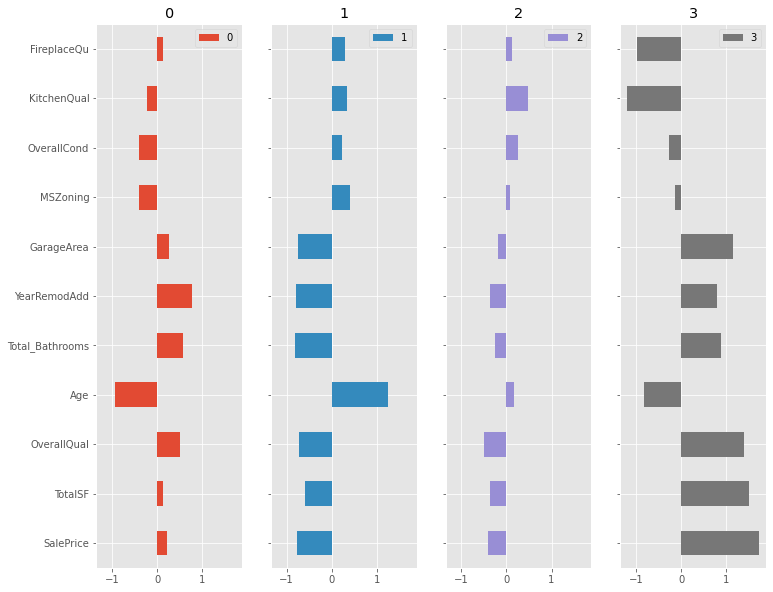

In [ ]:
cluster_mean[1:].plot(figsize=(12,10), kind="barh" , subplots=True, layout=(1, 4) , sharey=True)

#### 주성분 분석


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
house_pca = pca.fit(train_scaled).transform(train_scaled)

In [ ]:
house_pca

array([[ 2.64787423, -1.14274333],
       [ 0.59160484, -0.80163732],
       [ 3.27273499, -0.86695645],
       ...,
       [ 1.78389829,  3.57962252],
       [-3.03539318, -0.99023265],
       [-0.66050633, -1.19928913]])

In [ ]:
house_pca_df = pd.DataFrame(house_pca)
house_pca_df.columns = ["pca1","pca2"]

In [ ]:
train_scaled_df = pd.concat([train_scaled_df, house_pca_df], axis=1)

In [ ]:
train_scaled_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log,km_cluster,pca1,pca2
0,0.069617,-0.045768,-0.206346,-0.288764,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.387825,-0.325762,-1.046470,0.038930,1.736093,0.4596,0.586795,0,2.647874,-1.142743
1,-0.877169,-0.045768,0.512944,-0.075476,0.058926,0.744525,0.310054,-0.026316,-0.634124,-0.222579,...,0.031995,-0.325762,-0.188288,-0.017716,0.640132,0.4596,0.233882,2,0.591605,-0.801637
2,0.069617,-0.045768,-0.062488,0.230544,0.058926,-1.387256,0.310054,-0.026316,0.601627,-0.222579,...,0.585509,-0.325762,-0.980456,0.227753,1.736093,0.4596,0.763584,0,3.272735,-0.866956
3,0.306313,-0.045768,-0.446109,-0.084750,0.058926,-1.387256,0.310054,-0.026316,-1.869875,-0.222579,...,-0.514930,-0.325762,1.792130,-0.086502,-0.455829,0.4596,-0.426767,1,-1.522228,2.171157
4,0.069617,-0.045768,0.704755,0.788800,0.058926,-1.387256,0.310054,-0.026316,-0.634124,-0.222579,...,0.934750,-0.325762,-0.947449,1.086897,1.736093,0.4596,1.048721,3,5.718597,0.948546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1440,0.069617,-0.045768,-0.350204,-0.387617,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.053668,-0.325762,-0.947449,0.084787,0.640132,0.4596,0.141076,0,1.340956,-0.241171
1441,-0.877169,-0.045768,0.752707,0.587568,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,0.407594,-0.325762,-0.155281,1.453753,0.640132,0.4596,0.605037,2,1.782666,0.841906
1442,0.306313,-0.045768,-0.158393,-0.178967,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,1.152202,2.854821,1.065977,1.287858,-0.455829,0.4596,1.211364,0,1.783898,3.579623
1443,-0.877169,-0.045768,-0.062488,-0.053777,0.058926,0.744525,0.310054,-0.026316,0.601627,-0.222579,...,-0.486925,-0.325762,0.768914,-0.514051,-0.455829,0.4596,-0.388431,2,-3.035393,-0.990233


In [ ]:
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

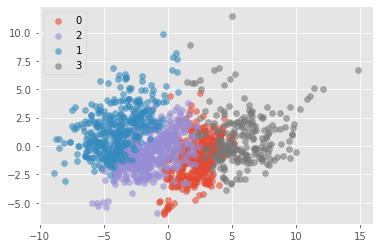

In [ ]:
for cl in train_scaled_df['km_cluster'].unique():
    plt.scatter(train_scaled_df.loc[train_scaled_df["km_cluster"] == cl ,'pca1'], train_scaled_df.loc[train_scaled_df["km_cluster"] == cl ,'pca2'], label=cl, c=my_colors[cl], alpha=0.6)
plt.legend()
plt.show()

In [ ]:
pca_comp_df = pd.DataFrame(pca.components_,columns=train_scaled_df.drop(["km_cluster","pca1","pca2"],axis=1).columns).T
pca_comp_df.columns = ["pca1","pca2"]

In [ ]:
pca_comp_df

,pca1,pca2
MSSubClass,-0.007451,-0.045197
MSZoning,-0.067692,0.062006
LotFrontage,0.089335,0.138855
LotArea,0.084628,0.168670
Street,0.010013,0.010760
...,...,...
Age,-0.197903,0.246229
TotalSF,0.218012,0.188240
Total_Bathrooms,0.189083,0.029206
hasPorch,0.091475,0.031042


## Appendix2. High-end residential


### 고급 주택의 조건을 분석하고 시각화하기


#### SalePrice 분포 확인하기


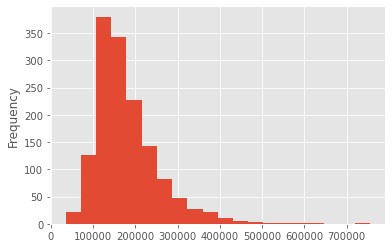

In [ ]:
train_df_le['SalePrice'].plot.hist(bins=20)

In [ ]:
train_df_le['SalePrice'].describe()

count      1445.000000
mean     179072.294118
std       75905.045476
min       34900.000000
25%      129900.000000
50%      162000.000000
75%      213000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
train_df['SalePrice'].quantile(0.9)

278000.0

#### 고급 주택 변수 추가하기


In [ ]:
train_df_le.loc[train_df["SalePrice"] >= 278000, "high_class"] = 1

In [ ]:
train_df_le["high_class"] = train_df_le["high_class"].fillna(0)

In [ ]:
train_df_le.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType,SaleCondition,SalePrice,hasHighFacility,Age,TotalSF,Total_Bathrooms,hasPorch,SalePrice_log,high_class
0,1,60,3,65.0,8450,1,3,3,0,4,...,8,4,208500.0,0,5,2566.0,4.0,1,12.247694,0.0
1,2,20,3,80.0,9600,1,3,3,0,2,...,8,4,181500.0,0,31,2524.0,3.0,1,12.109011,0.0
2,3,60,3,68.0,11250,1,0,3,0,4,...,8,4,223500.0,0,7,2706.0,4.0,1,12.317167,0.0
3,4,70,3,60.0,9550,1,0,3,0,0,...,8,0,140000.0,0,91,2473.0,2.0,1,11.849398,0.0
4,5,60,3,84.0,14260,1,0,3,0,2,...,8,4,250000.0,0,8,3343.0,4.0,1,12.429216,0.0


#### 결정 트리를 시각화하기


In [ ]:
from sklearn import tree
import pydotplus
from six import StringIO

In [ ]:
tree_x = train_df_le[["TotalSF","OverallQual","Age","GrLivArea","GarageCars","Total_Bathrooms","GarageType",
"YearRemodAdd","GarageArea","CentralAir","MSZoning","OverallCond","KitchenQual","FireplaceQu","1stFlrSF"]]
tree_y = train_df_le[["high_class"]]

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(tree_x, tree_y)

In [ ]:
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,feature_names=tree_x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

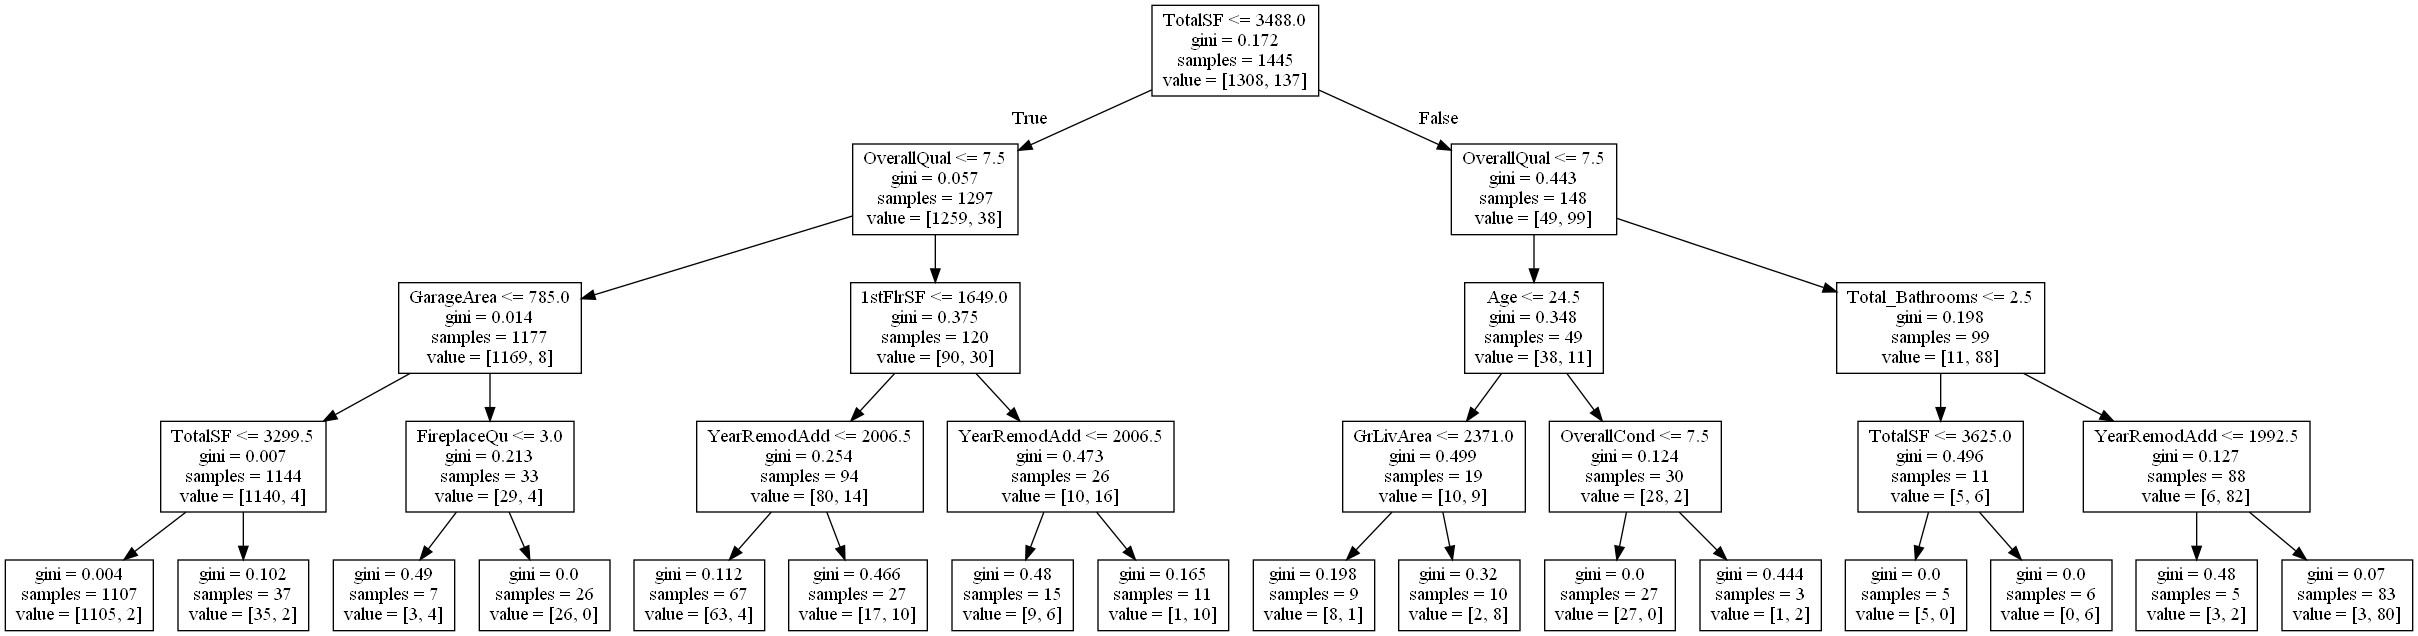

In [ ]:
from IPython.display import Image
Image(graph.create_png())